# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [3]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [4]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [5]:
def norm_filter(adata, mito_genes, RB_genes_in_data, log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [6]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [7]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('DEA/' + cell_type):
        os.makedirs('DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    #adata_celltype = adata_celltype[adata_celltype.obs['final_subclusters'].isin([cell_type]),:]
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)

    
    expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [8]:
def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [9]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [10]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = './input/'
outdir = './output_Nov/'
figures = './figures/'

In [11]:
adata_final_high_var = sc.read_h5ad(outdir+'adata_final_high_var_final_clusters_updated.h5ad')

In [12]:
adata_final_high_var.shape

(23060, 18947)

# Oligodendrocyte subset

In [13]:
adata_oligo = deepcopy(adata_final_high_var)
adata_oligo = adata_oligo[adata_oligo.obs['final_subclusters'].isin(['Oligodendrocytes']),:]
adata_oligo.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4804, 18947)

In [14]:
broad_clusters = adata_oligo.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_oligo.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 1380, '1819_C1029_Ctrl_ES_Cort_IGO_10837_23': 363})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 2752, '1821_996_VE_ES_Cort_IGO_10875_6': 309})


In [15]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [16]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [17]:
adata_oligo = adata[adata_oligo.obs.index, :]
adata_oligo.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4804, 22292)

## QC

In [18]:
adata_oligo, mito_genes, RB_genes_in_data = qc_metrics(adata_oligo)
markers = []
if type(adata_oligo.X)==np.ndarray:
    pass
else:
    print(type(adata_oligo.X))
    #print(adata_norm.X.shape)
    adata_oligo.X = adata_oligo.X.toarray()
    #print(adata_norm.X.shape)
adata_oligo.X = pd.DataFrame(data=adata_oligo.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [19]:
adata_oligo.shape

(4804, 22292)

## Normalization

In [20]:
markers = []
adata_oligo, markers = norm_filter(adata_oligo, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_oligo.obs.head()

(4804, 22292)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4804, 13657)
(4804, 13479)
(4804, 13466)
True
Im here2


Trying to set attribute `.uns` of view, copying.


1999
1999


Sample ID  \
cell_barcodes                                                                          
122490832730908_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
126889101519772_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
204882352170859_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
121416400693035_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   

                                                  Condition   B_region  \
cell_barcodes                                                            
122490832730908_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
126889101519772_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
204882352170859_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
121416400693035_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   

                                                   n_genes_by_counts  \
cell_barcodes                                                          
122490832730908_1822_996_VE_ES_BS_IGO_10875_7                   1396   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7                    901   
126889101519772_1820_C1029_Ctrl_ES_BS_IGO_10856_3               1276   
204882352170859_1820_C1029_Ctrl_ES_BS_IGO_10856_3               1200   
121416400693035_1820_C1029_Ctrl_ES_BS_IGO_10856_3               1089   

                                                   log1p_n_genes_by_counts  \
cell_barcodes                                                                
122490832730908_1822_996_VE_ES_BS_IGO_10875_7                     7.242082   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7                     6.804615   
126889101519772_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 7.152269   
204882352170859_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 7.090910   
121416400693035_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 6.993933   

                                                   total_counts  \
cell_barcodes                                                     
122490832730908_1822_996_VE_ES_BS_IGO_10875_7            2602.0   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7            1363.0   
126889101519772_1820_C1029_Ctrl_ES_BS_IGO_10856_3        2550.0   
204882352170859_1820_C1029_Ctrl_ES_BS_IGO_10856_3        2198.0   
121416400693035_1820_C1029_Ctrl_ES_BS_IGO_10856_3        1855.0   

                                                   log1p_total_counts  \
cell_barcodes                                                           
122490832730908_1822_996_VE_ES_BS_IGO_10875_7                7.864420   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7                7.218177   
126889101519772_1820_C1029_Ctrl_ES_BS_IGO_10856_3            7.844241   
204882352170859_1820_C1029_Ctrl_ES_BS_IGO_10856_3            7.695758   
121416400693035_1820_C1029_Ctrl_ES_BS_IGO_10856_3            7.526179   

                                                   pct_counts_in_top_50_genes  \
cell_barcodes                                                                   
122490832730908_1822_996_VE_ES_BS_IGO_10875_7                       24.673328   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7                       22.743947   
126889101519772_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   28.627451   
204882352170859_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   27.479527   
121416400693035_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   24.905660   

                                                   pct_counts_in_top_100_genes  \
cell_barcodes                                                                    
122490832730908_1822_996_VE_ES_BS_IGO_10875_7                        33.282091   
192729653894382_1822_996_VE_ES_BS_IGO_10875_7                        32.208364   
126889101

## PCA

[[-3.321928  -3.321928  -3.321928  ... -3.321928  -3.321928  -3.321928 ]
 [-3.321928  -3.321928  -3.321928  ... -3.321928  -3.321928  -3.321928 ]
 [-0.3181789 -3.321928  -3.321928  ... -3.321928  -3.321928  -3.321928 ]
 ...
 [-0.8636184 -3.321928  -3.321928  ... -3.321928  -3.321928  -3.321928 ]
 [-3.321928  -3.321928  -3.321928  ... -3.321928  -3.321928  -3.321928 ]
 [-3.321928  -3.321928  -3.321928  ... -3.321928  -3.321928  -3.321928 ]]
(4804, 13466)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


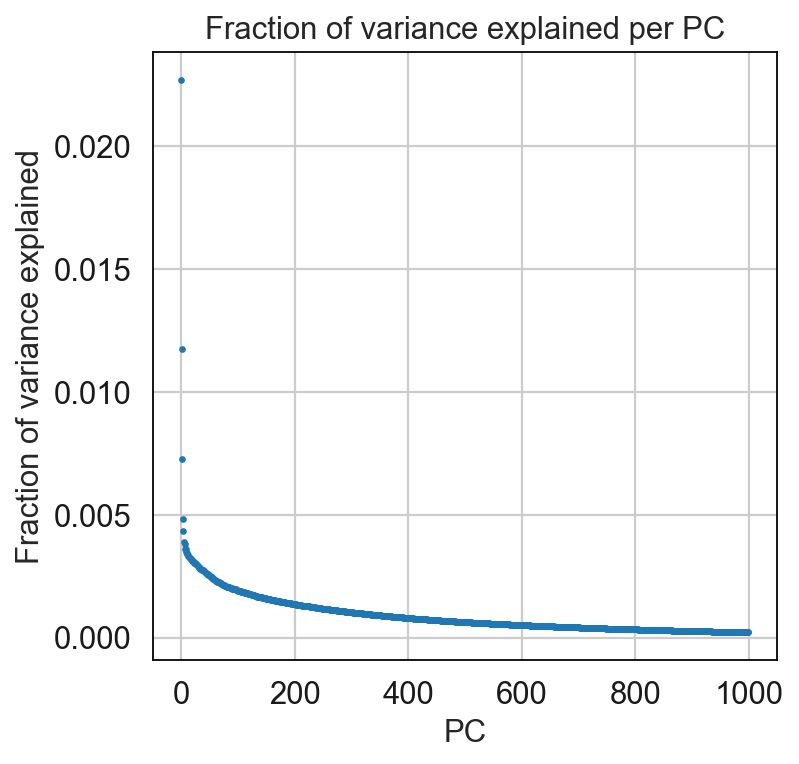

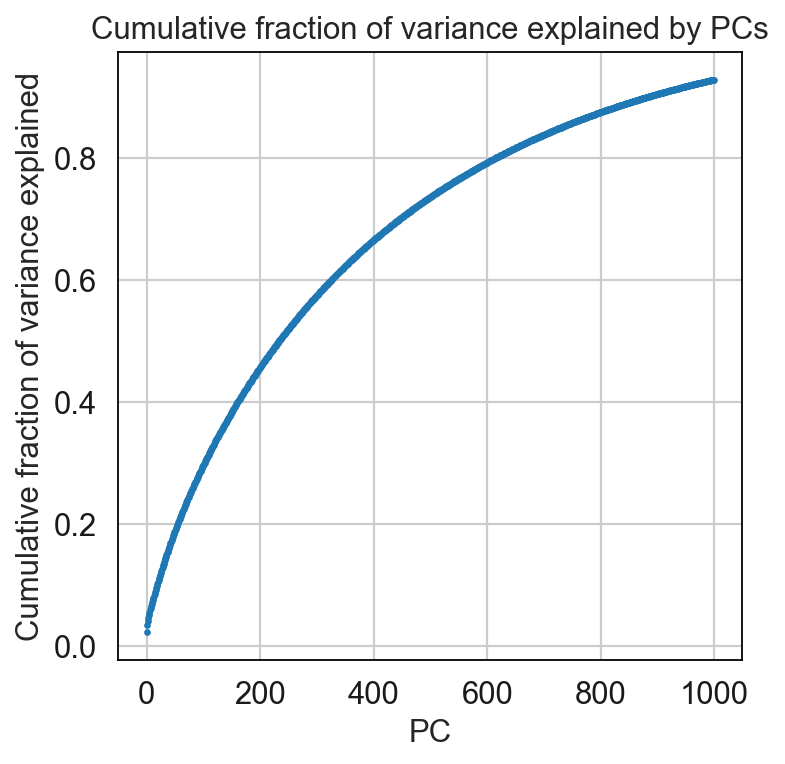

Knee point: 22
Explained variance: 0.1115016


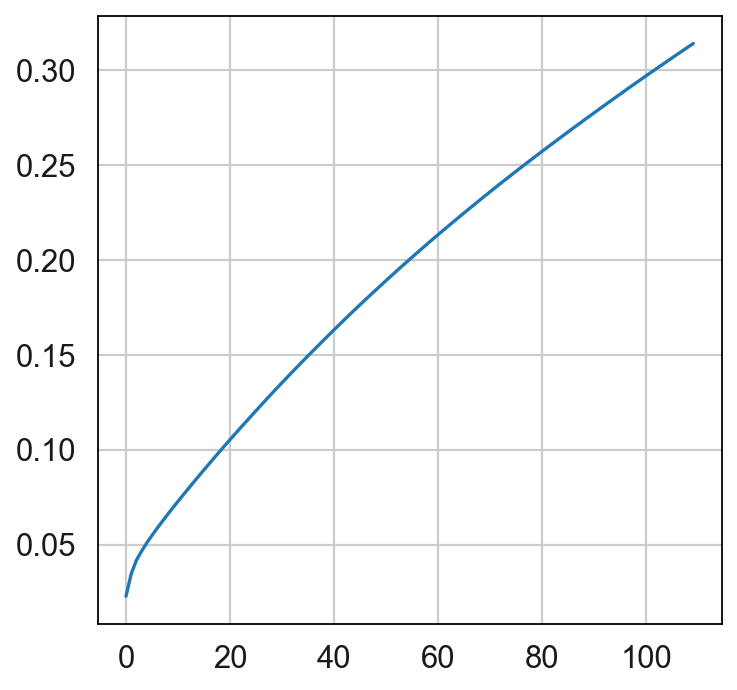

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


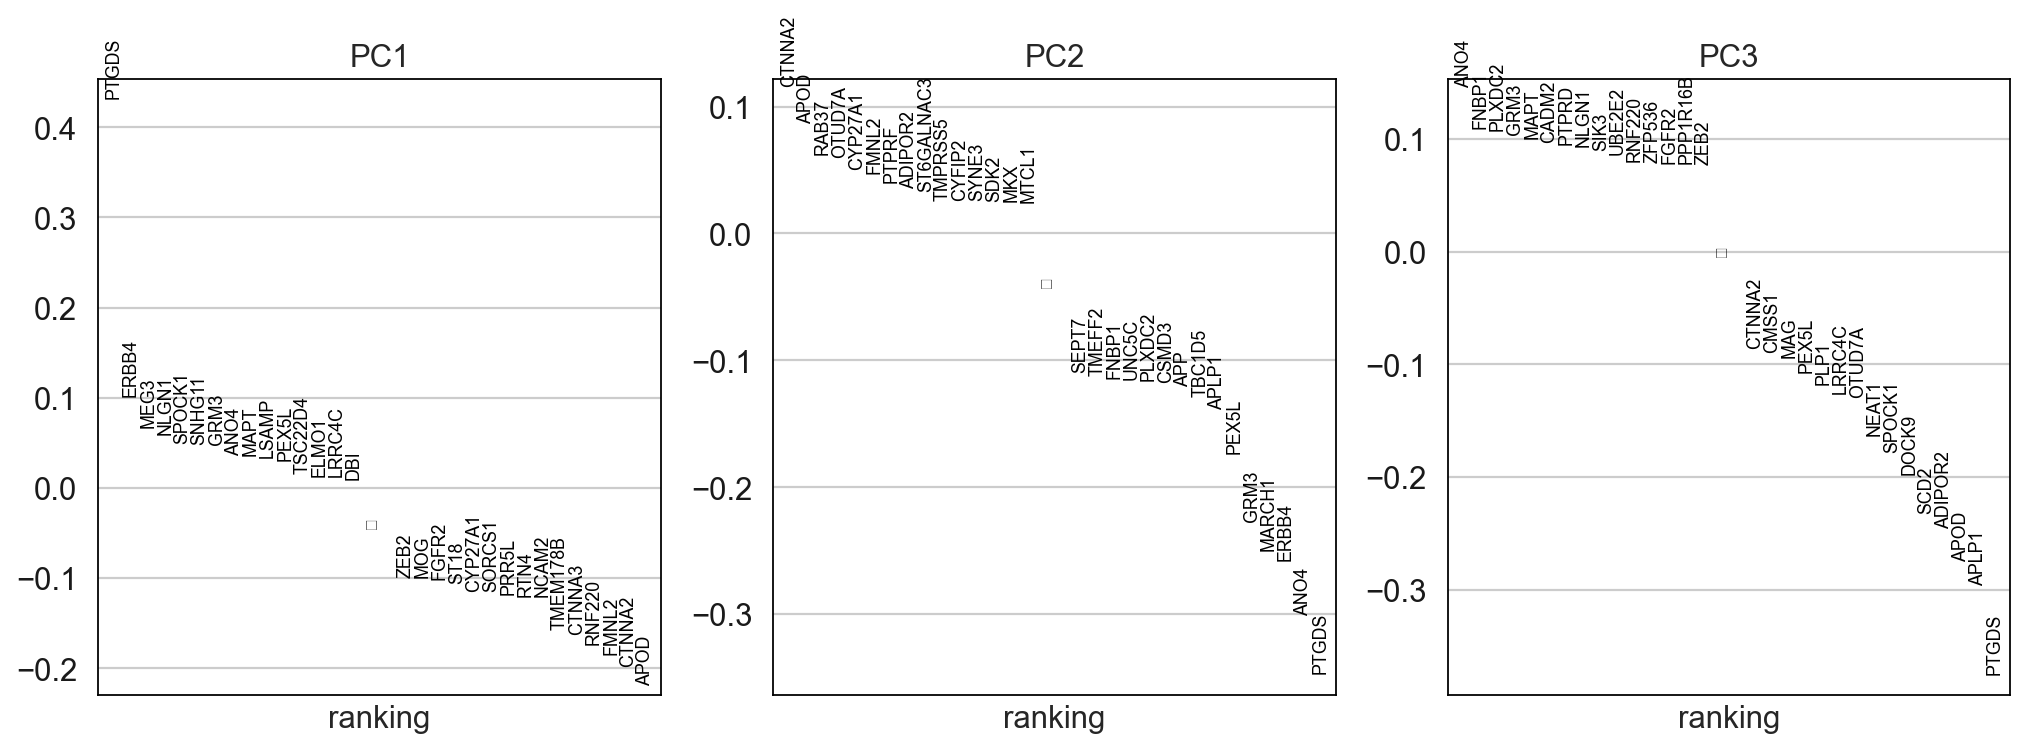

(4804, 13466)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
sc.set_figure_params(figsize=(5, 5))
adata_oligo = run_pca_knee(adata_oligo)#, 0.5)
adata_oligo.obs['PC 1'] = adata_oligo.obsm['X_pca'][:,0] # optional
adata_oligo.obs['PC 2'] = adata_oligo.obsm['X_pca'][:,1]
adata_oligo.obs['PC 3'] = adata_oligo.obsm['X_pca'][:,2]

print(adata_oligo.shape)
adata_oligo.X = pd.DataFrame(adata_oligo.X).fillna(0).values
index_list = np.arange(adata_oligo.shape[0])
np.random.shuffle(index_list)
adata_oligo = adata_oligo[index_list,:]

In [22]:
print(adata_oligo.shape)
adata_oligo.X = pd.DataFrame(adata_oligo.X).fillna(0).values
index_list = np.arange(adata_oligo.shape[0])
np.random.shuffle(index_list)
adata_oligo = adata_oligo[index_list,:]

(4804, 13466)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4403250217437744 seconds
Jaccard graph constructed in 3.1332192420959473 seconds
Wrote graph to binary file in 0.2602360248565674 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.699316
After 2 runs, maximum modularity is Q = 0.700484
After 6 runs, maximum modularity is Q = 0.702227
After 22 runs, maximum modularity is Q = 0.704386
Louvain completed 42 runs in 2.498784065246582 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 7.025986194610596 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3434460163116455 seconds
Jaccard graph constructed in 1.0622239112854004 seconds
Wrote graph to binary file in 0.2005631923675537 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.650975
After 2 runs, maximum modularity is Q = 0.652073
After 22 runs, maximum modularity is Q = 0.653561
Louvain completed 42 runs in 2.861462116241455 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 5.126024961471558 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3728067874908447 seconds
Jaccard graph constructed in 1.0407171249389648 seconds
Wrote graph to binary file in 0.2721590995788574 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.637274
After 2 runs, maximum modularity is Q = 0.638726
After 3 runs, maximum modularity is Q = 0.642317
Louvai

Text(0.5, 0, 'k')

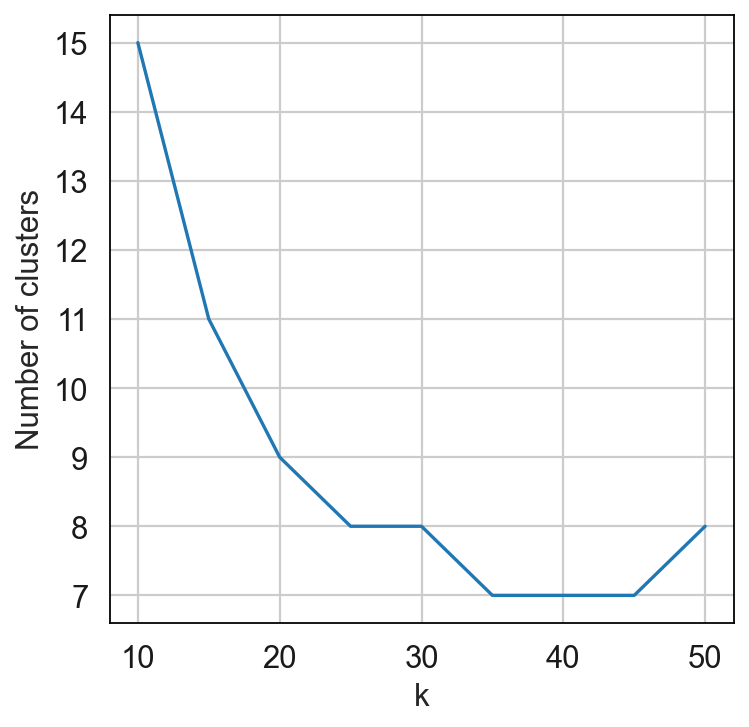

In [23]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_oligo.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_oligo.obs['PhenoGraph_clusters_oligo'+str(k)] = pd.Categorical(communities)
    adata_oligo.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_oligo.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [24]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_oligo.obs['PhenoGraph_clusters_oligo'+str(k_list[run1])].values,
            adata_oligo.obs['PhenoGraph_clusters_oligo'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

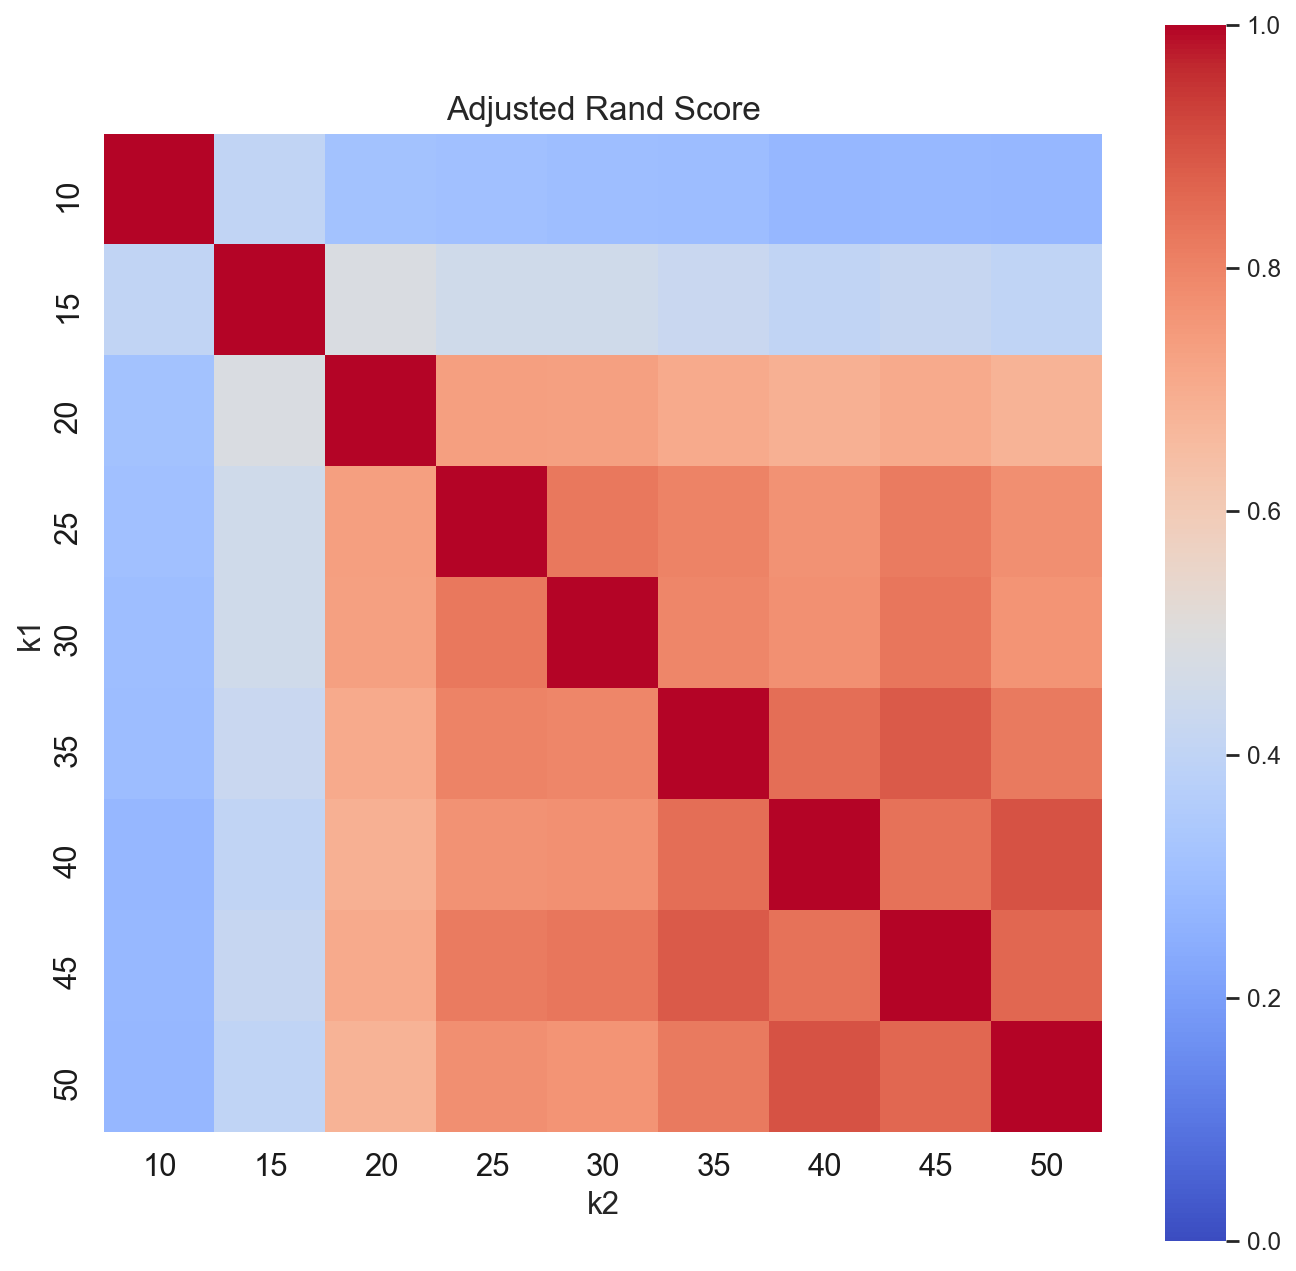

In [25]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [34]:
k = 35 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_oligo.obsm['X_pca']),k=k) # run PhenoGraph
adata_oligo.obs['PhenoGraph_clusters_oligo'] = pd.Categorical(communities)
adata_oligo.uns['PhenoGraph_Q'] = Q
adata_oligo.uns['PhenoGraph_k'] = k

Finding 35 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3800928592681885 seconds
Jaccard graph constructed in 2.8522818088531494 seconds
Wrote graph to binary file in 0.5293660163879395 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.608614
After 2 runs, maximum modularity is Q = 0.619989
After 6 runs, maximum modularity is Q = 0.622059
Louvain completed 26 runs in 2.631906032562256 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 7.077939033508301 seconds


## Vizualize Oligo sub-clusters

In [35]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_oligo, method='umap', use_rep='X_pca')
sc.tl.umap(adata_oligo, random_state=None)

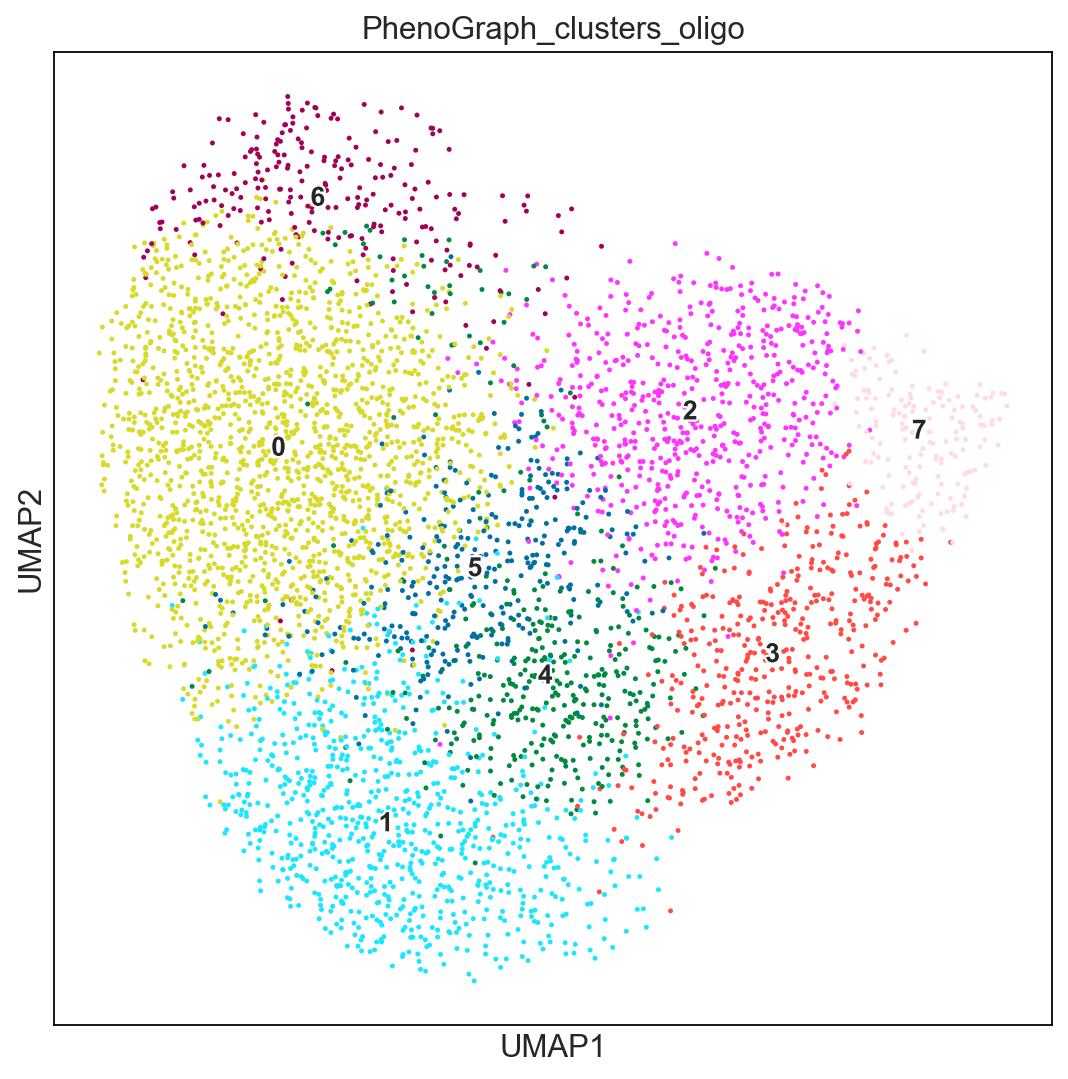

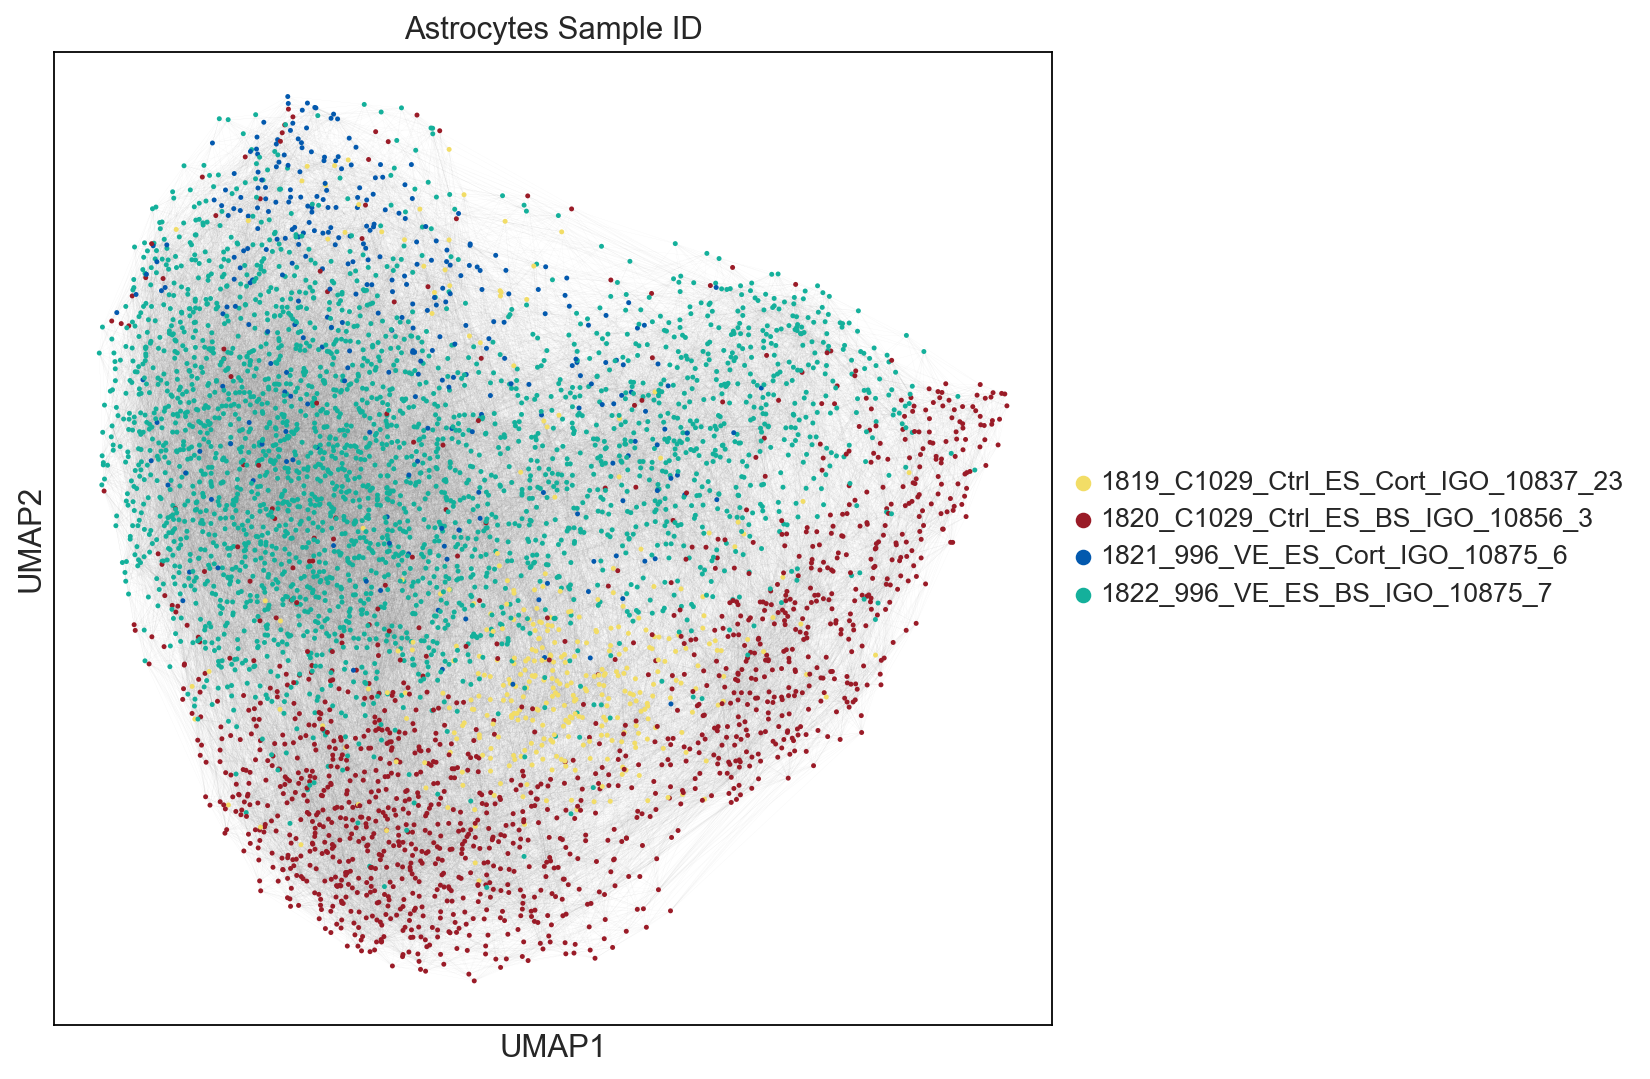

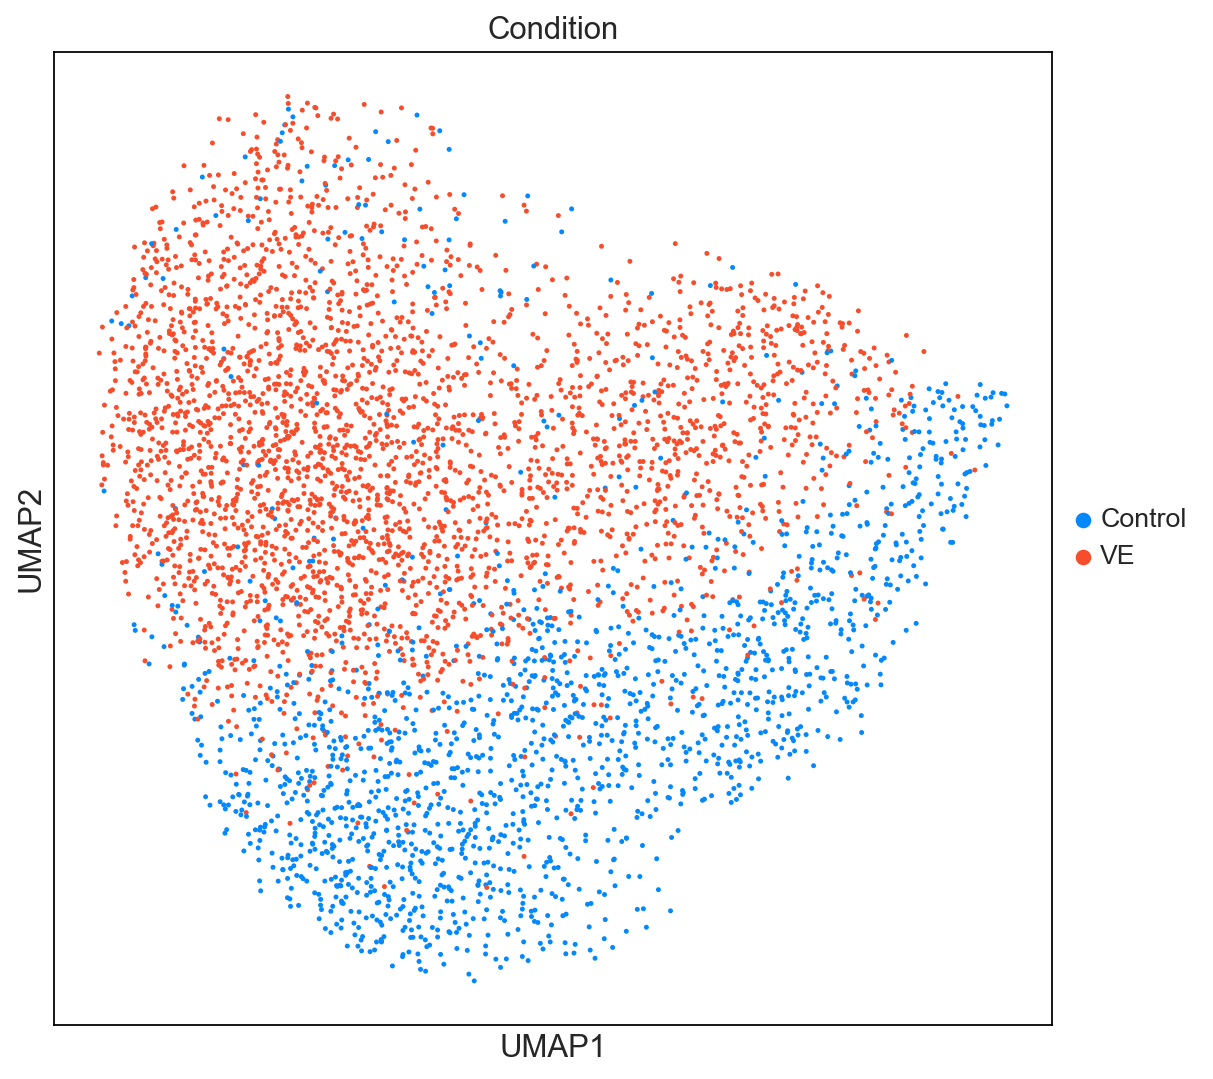

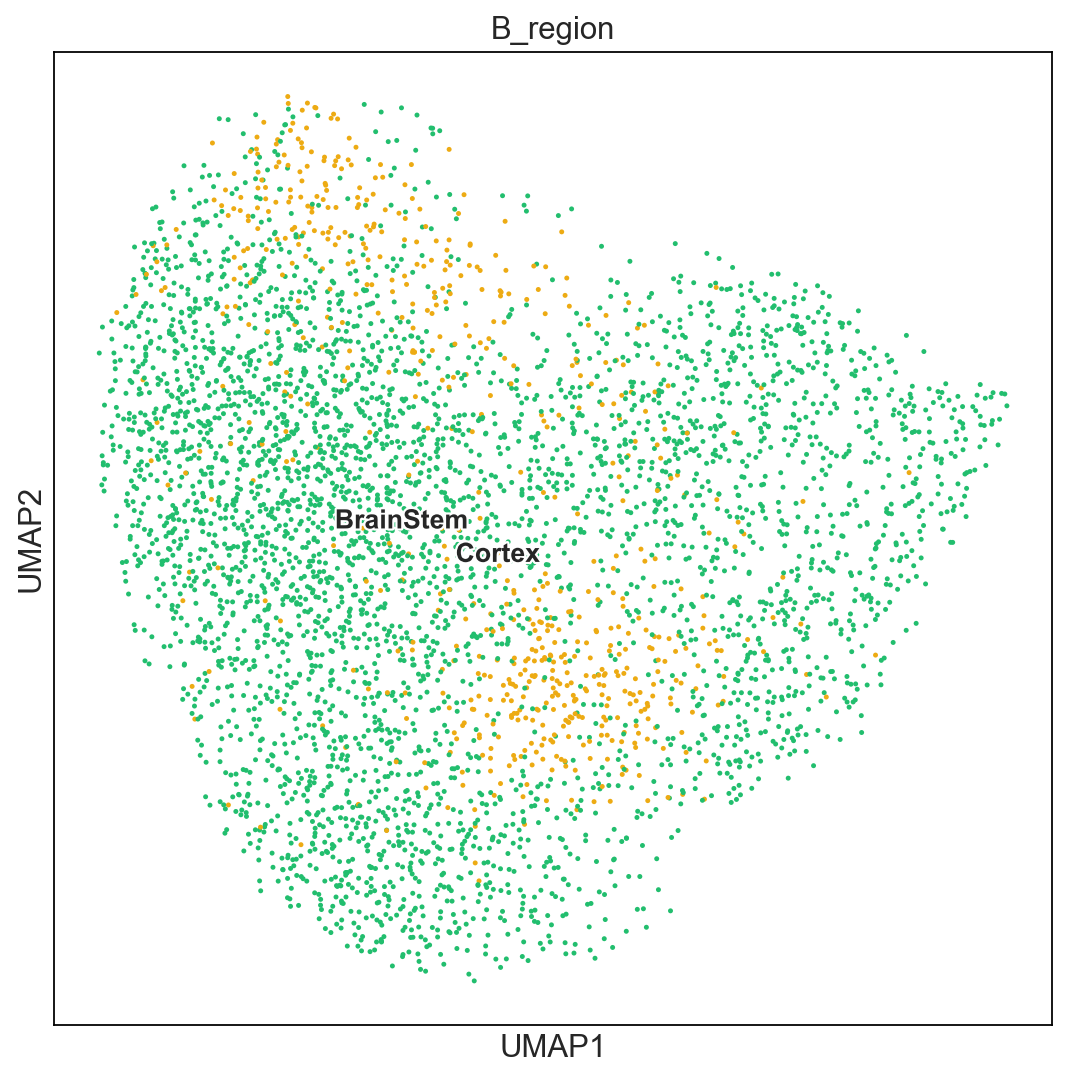

In [36]:
sc.pl.umap(adata_oligo,
           color=['PhenoGraph_clusters_oligo'],
           ncols=2,
           sort_order=False,
           palette=godsnot_64, # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2,)

sc.pl.umap(adata_oligo, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=20, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_oligo,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2)

sc.pl.umap(adata_oligo,
           color=['B_region'],
           ncols=2,
           sort_order=False,
           palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 20,
           legend_fontoutline=2)



## Find markers (Oligo clusters)

In [37]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Oligo0',
    1 : 'Oligo1',
    2 : 'Oligo2',
    3 : 'Oligo3',
    4 : 'Oligo4',
    5 : 'Oligo5',
    6 : 'Oligo6',
    7 : 'Oligo7'}

adata_oligo.obs['PhenoGraph_clusters_oligo_str'] = adata_oligo.obs['PhenoGraph_clusters_oligo'].map(cl_int_to_str).astype('category')

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


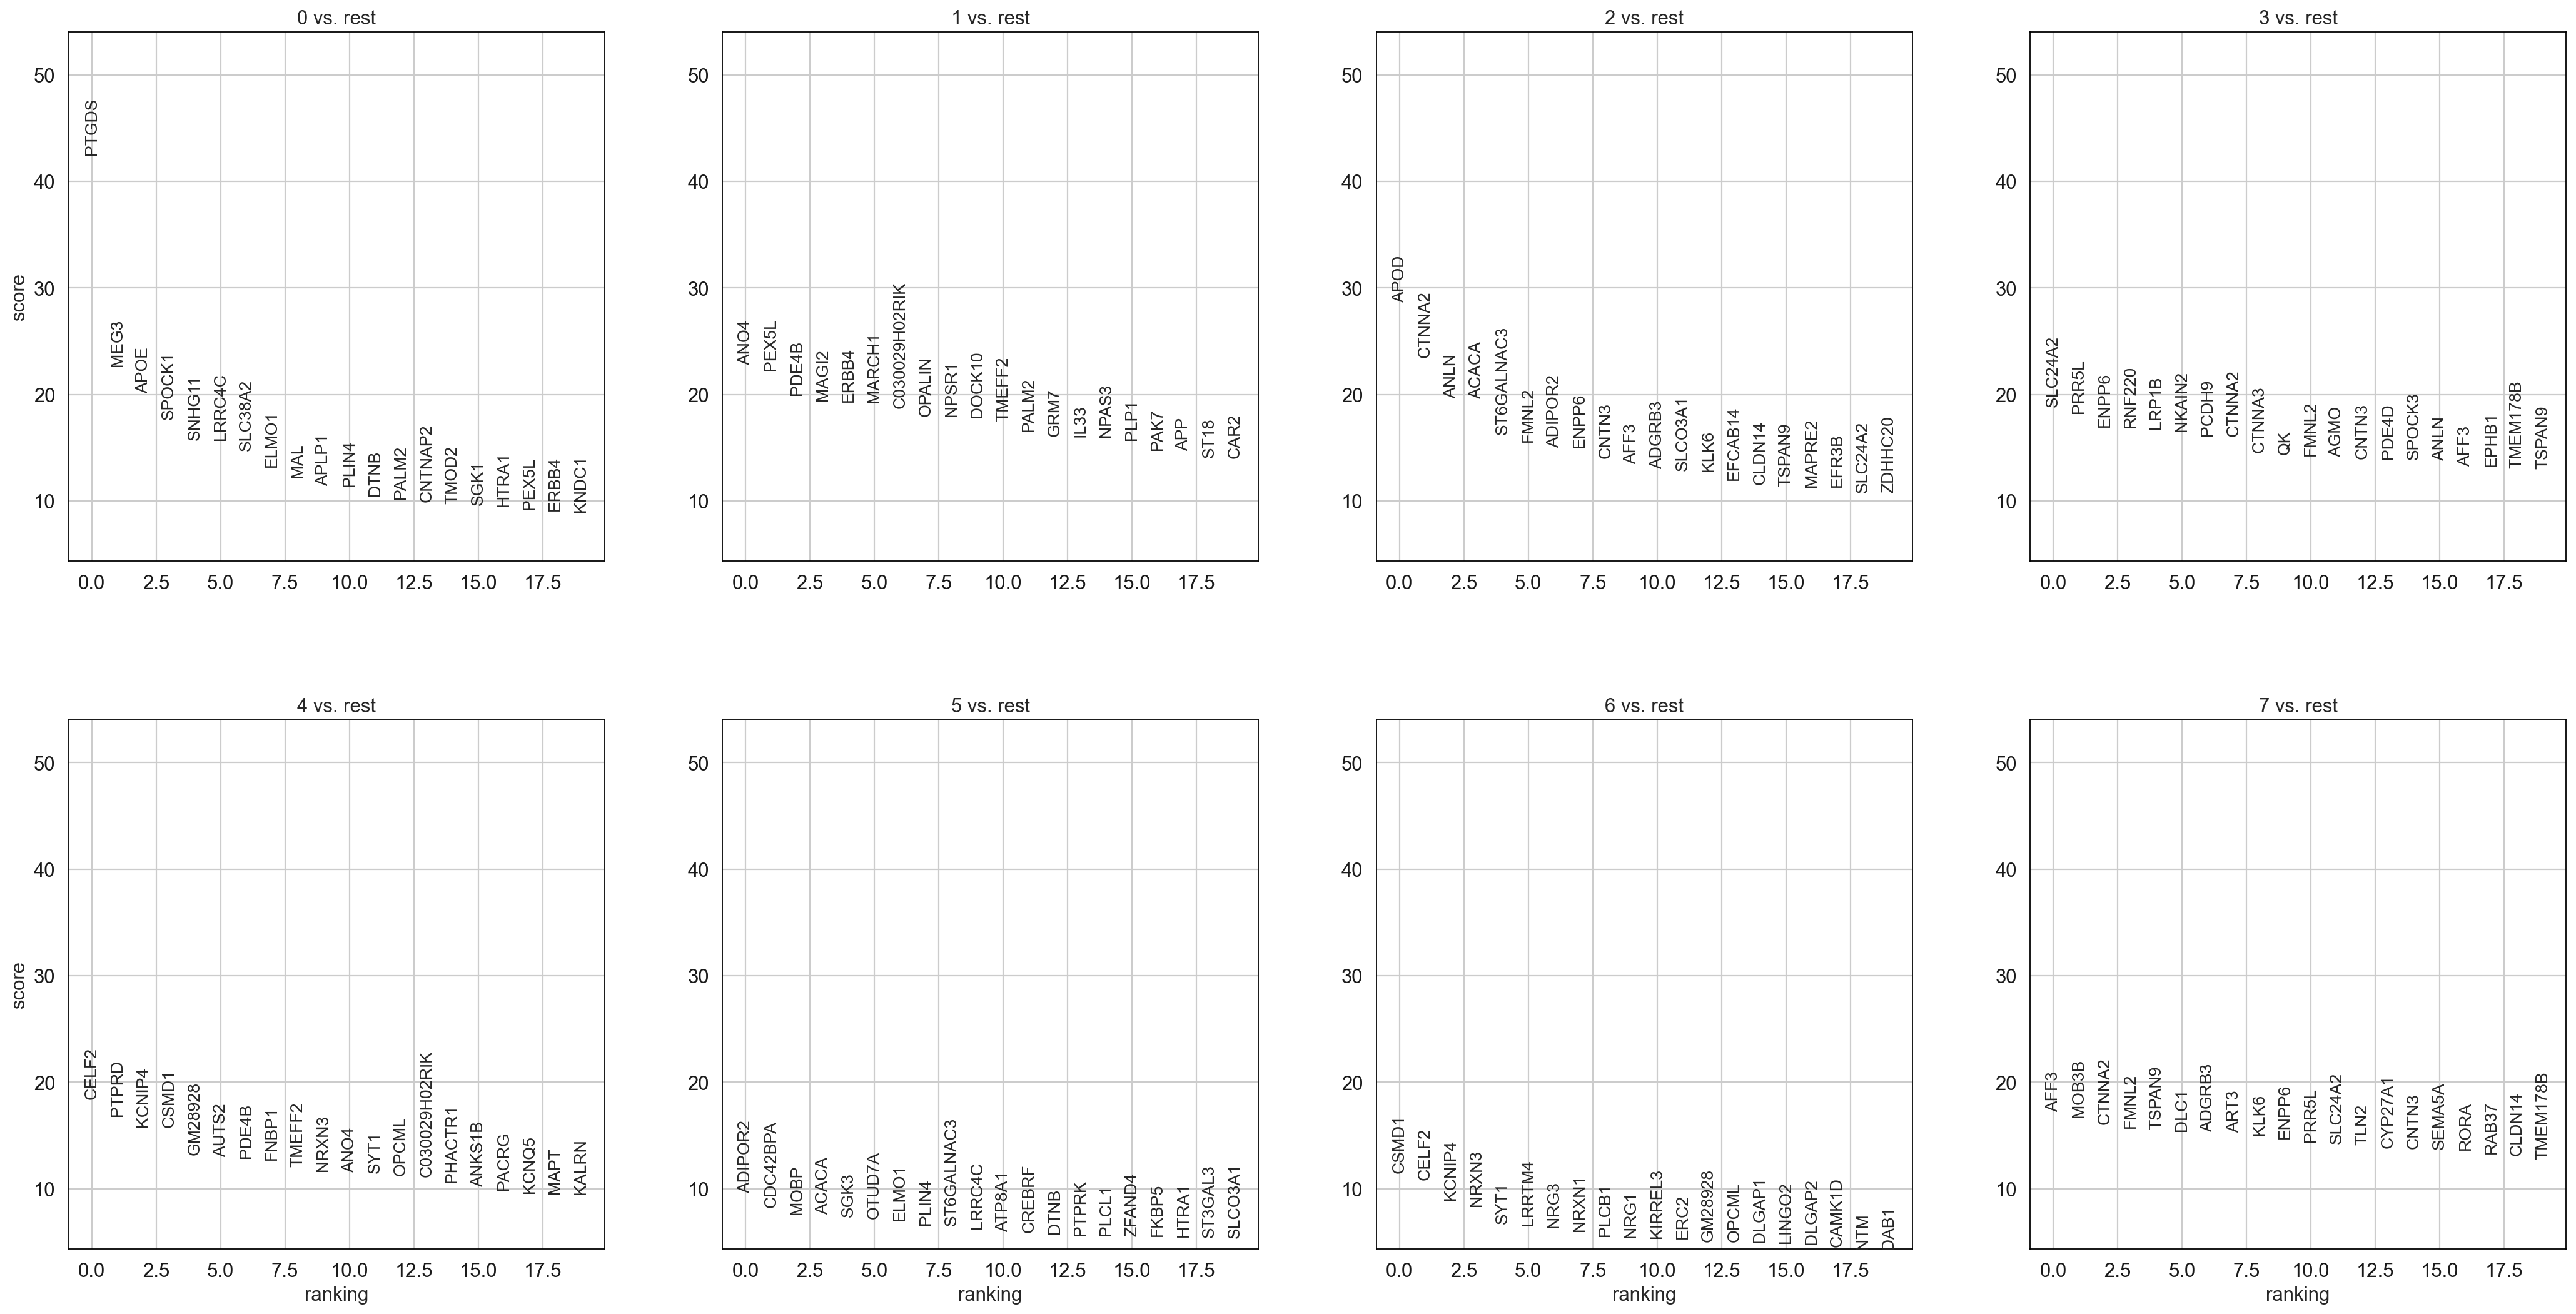

In [38]:
sc.tl.rank_genes_groups(adata_oligo, groupby='PhenoGraph_clusters_oligo', key_added="ranked_genes_pheno_oligo", method='wilcoxon')
sc.pl.rank_genes_groups(adata_oligo, key = 'ranked_genes_pheno_oligo', fontsize=12)

## Visualize marker genes using heatmap

In [39]:
adata_oligo.layers['scaled'] = sc.pp.scale(adata_oligo, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_oligo_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

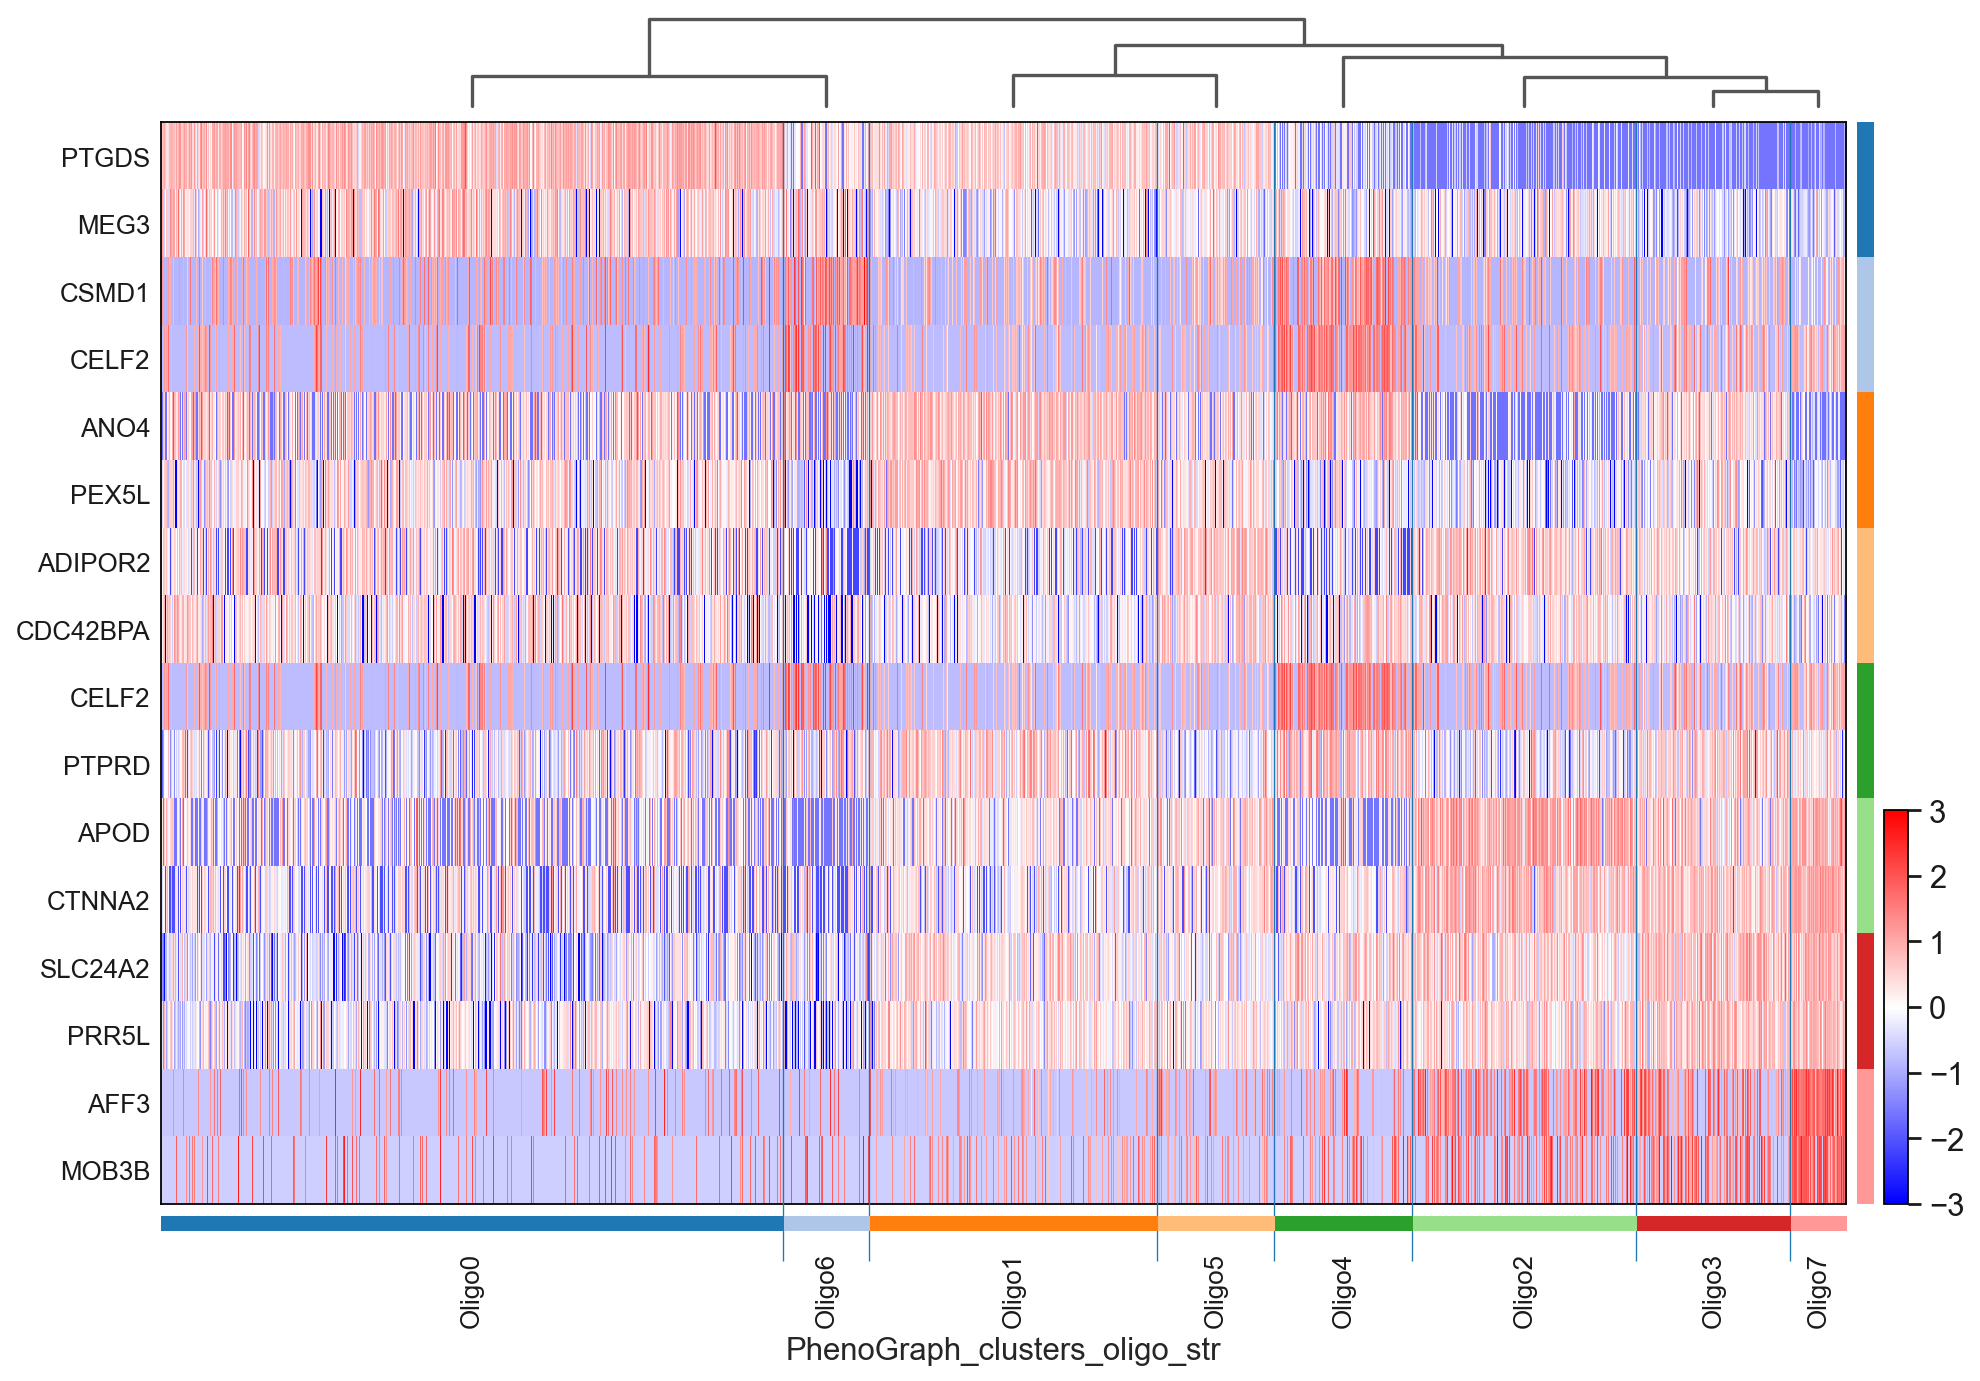

In [40]:
sc.tl.rank_genes_groups(adata_oligo, groupby='PhenoGraph_clusters_oligo_str', n_genes=adata_oligo.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_oligo, n_genes=2, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

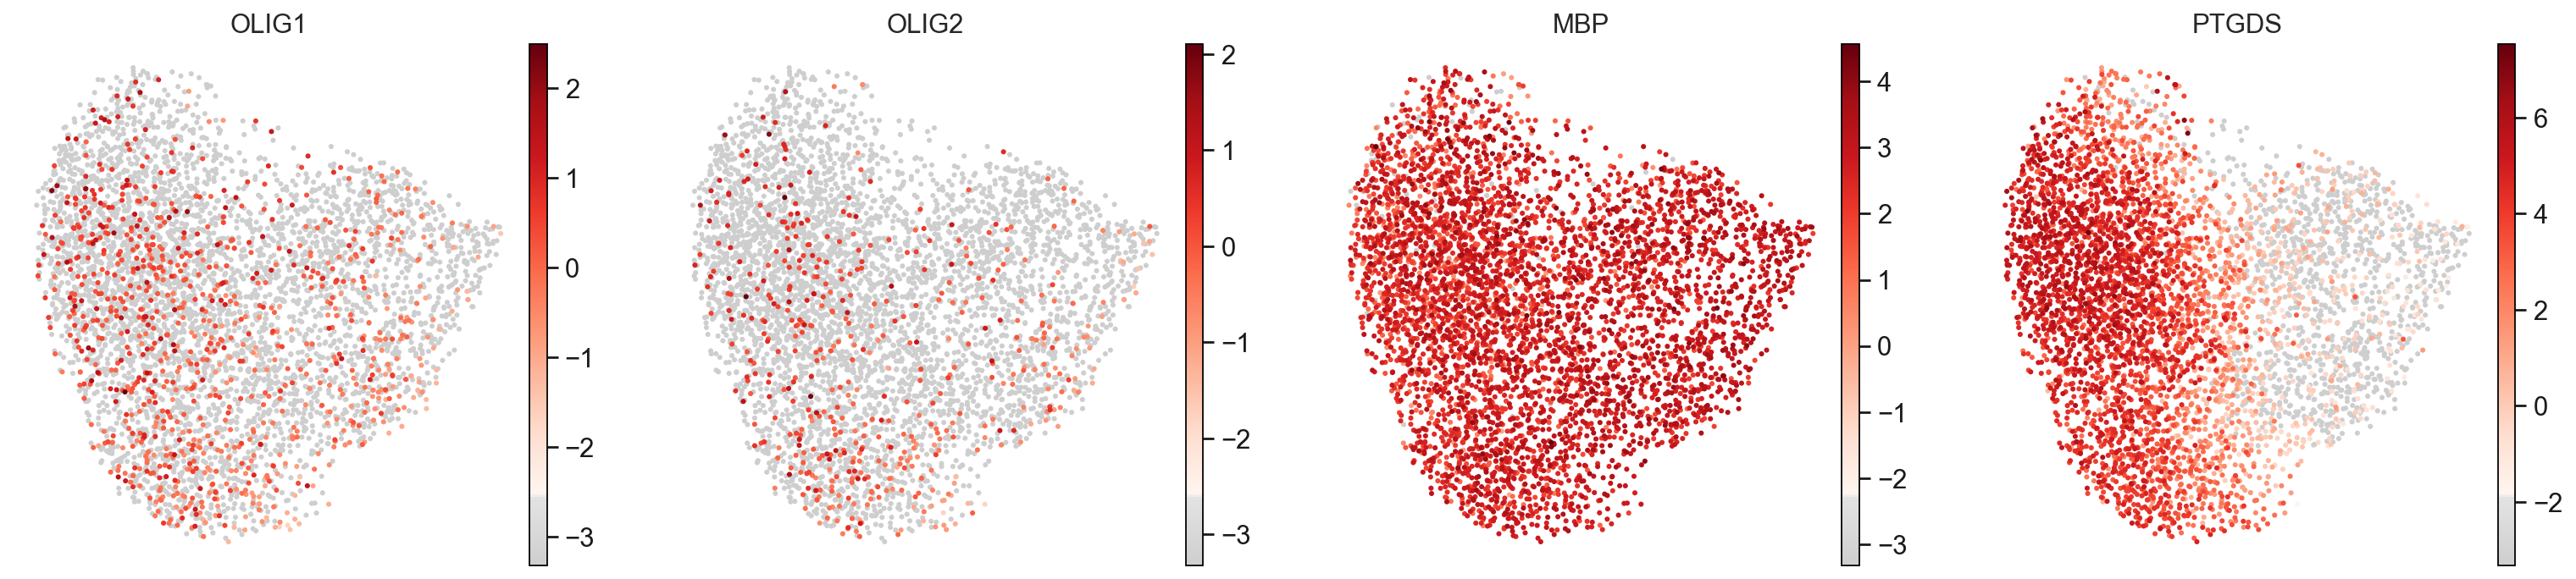

In [41]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_oligo,
           size = 30,
           color=['OLIG1','OLIG2','MBP','PTGDS'],
           color_map=mymap,
          frameon=False, )

## Save result Adata Oligodendrocytes

In [42]:
#adata_oligo.write_h5ad(outdir+'adata_high_var_Oligo_clusters.h5ad')

In [11]:
adata_oligo = sc.read_h5ad(outdir+'adata_high_var_Oligo_clusters.h5ad')

## Differential expression with MAST for Cortex & Brainstem

Load the adata object that holds the latest cell type annotations..

In [80]:
run_MAST_for_celltype(adata_oligo, "Oligodendrocytes")

Oligodendrocytes	Dimensions	(4804, 13466)
Files written for Oligodendrocytes
Running ./runMAST.R DEA/Oligodendrocytes/adata_Oligodendrocytes_exp_mat.csv DEA/Oligodendrocytes/adata_Oligodendrocytes_cdata.csv DEA/Oligodendrocytes/MAST_DEA_Oligodendrocytes_cort.csv DEA/Oligodendrocytes/MAST_DEA_Oligodendrocytes_bs.csv


'Finished running MAST on( Oligodendrocytes) in 962.3206553650002 seconds.'

## Oligo Brainstem

In [43]:
adata_oligo_BS = adata_oligo.copy()
adata_oligo_BS = adata_oligo_BS[adata_oligo_BS.obs['B_region'].isin(['BrainStem']),:]
adata_oligo_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4132, 13466)

In [44]:
adata_oligo_BS.obs.Condition.value_counts()

VE         2752
Control    1380
Name: Condition, dtype: int64

Trying to set attribute `.uns` of view, copying.


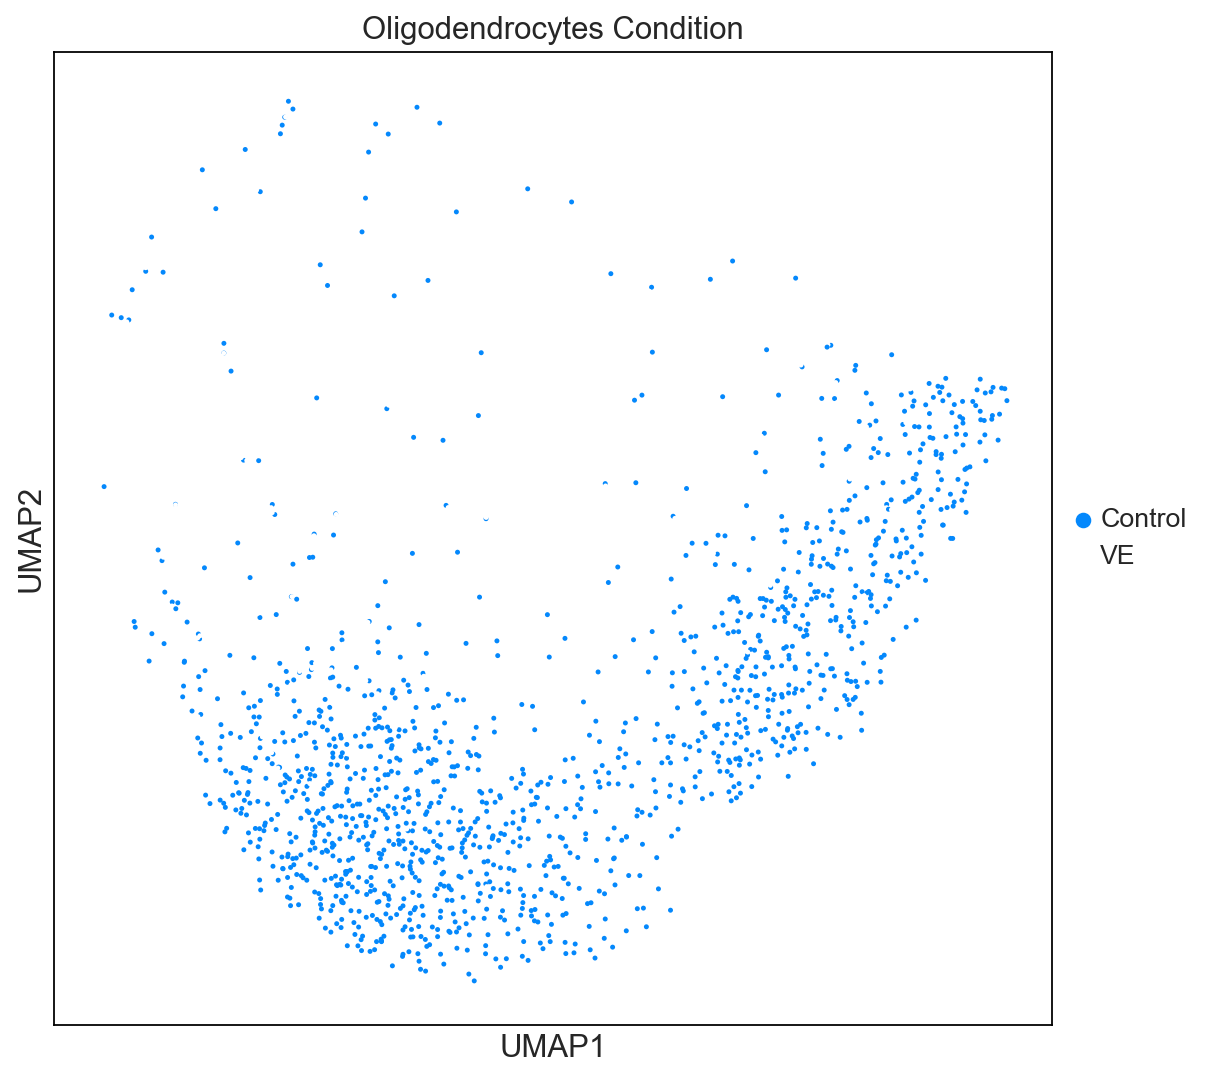

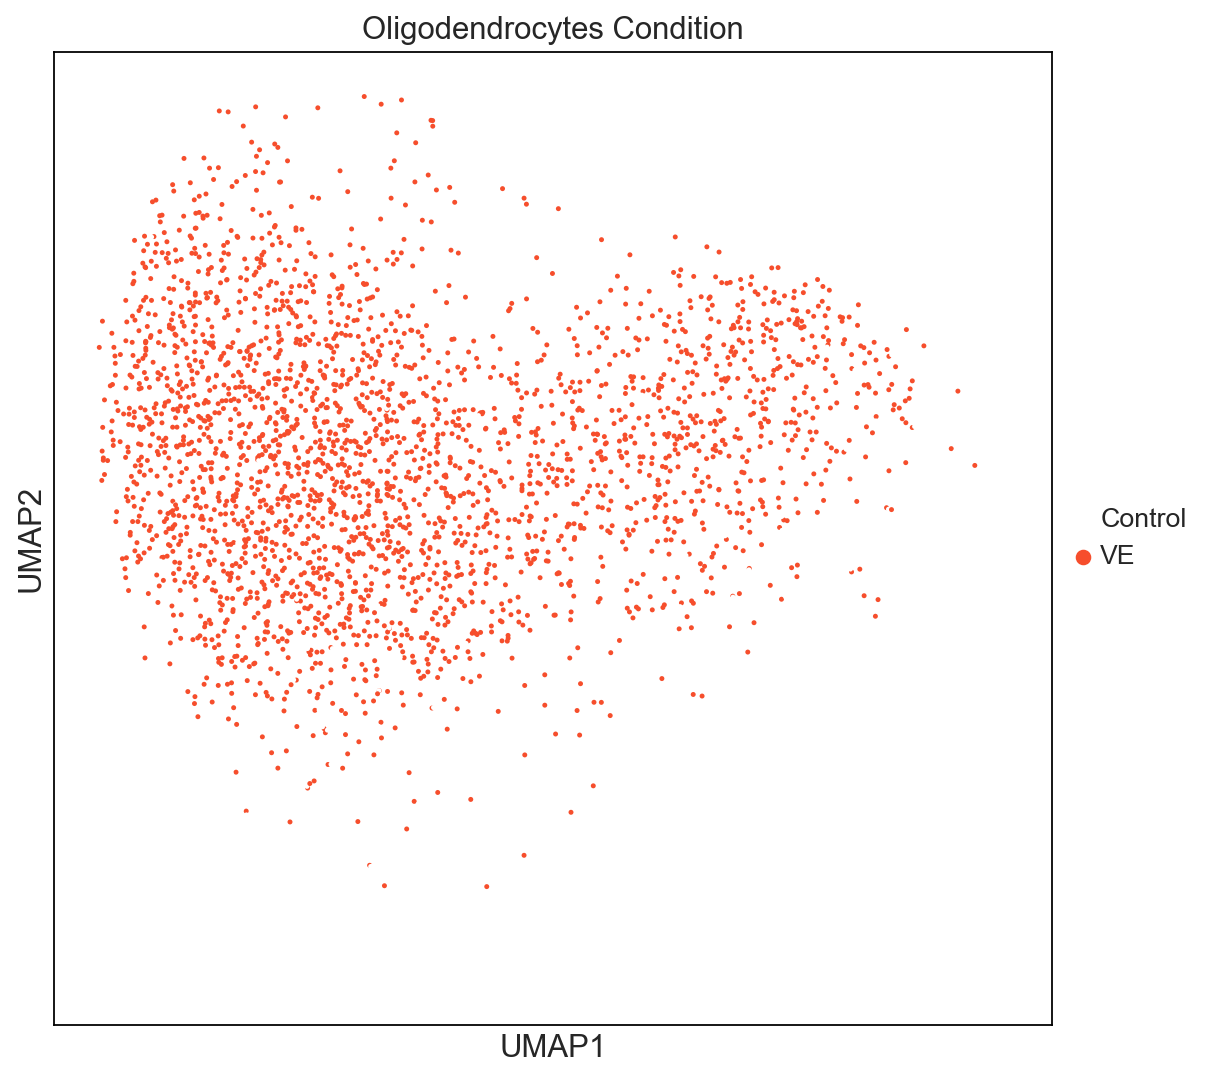

In [45]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_BS, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=20, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Condition"])


sc.pl.umap(adata_oligo_BS, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=20, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Condition"])

### Oligodendrocytes BS control 

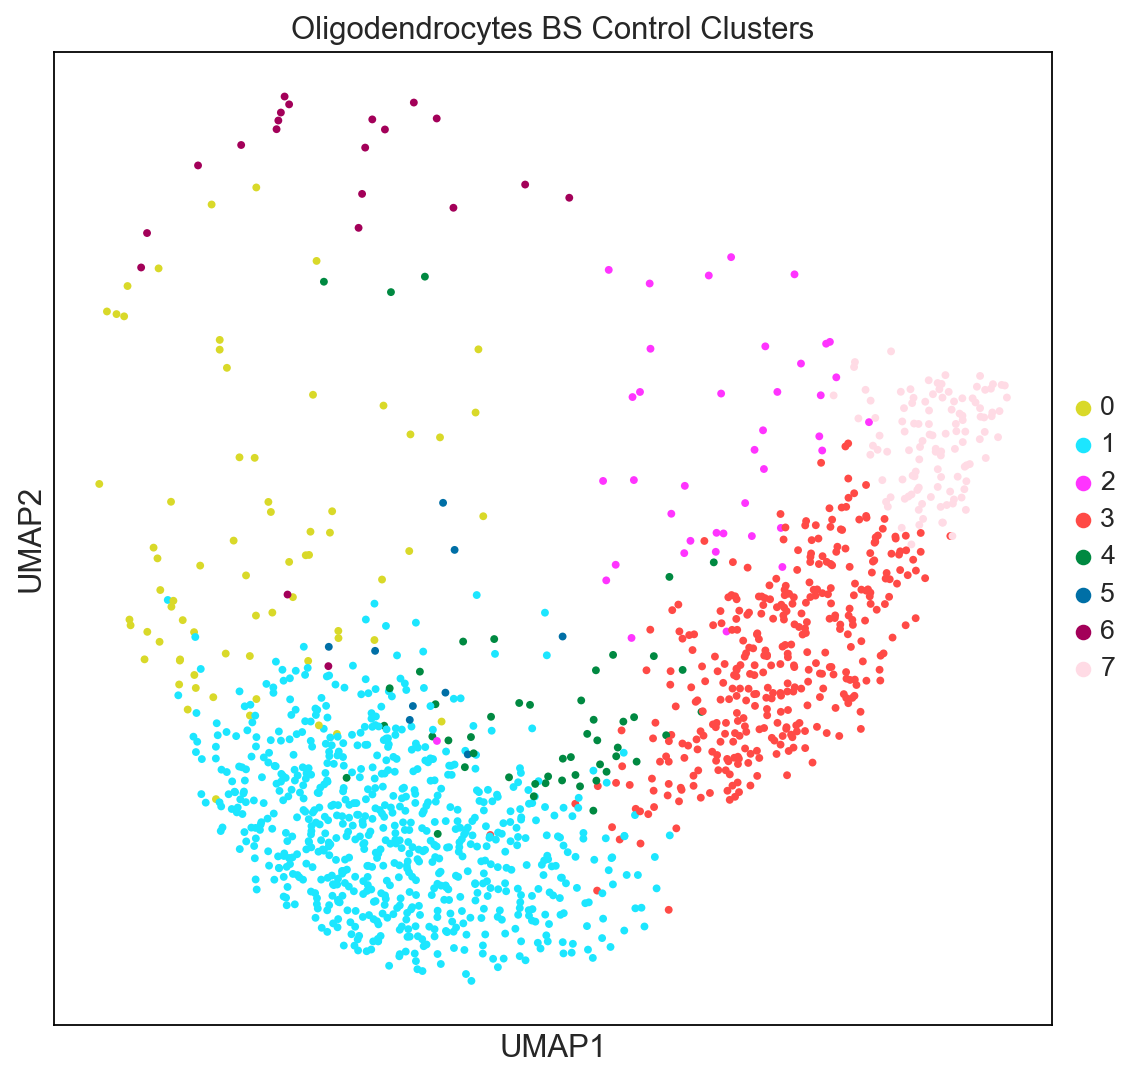

In [46]:
adata_oligo_BS_control = adata_oligo_BS[adata_oligo_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_BS_control, 
           color= ['PhenoGraph_clusters_oligo'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes BS Control Clusters"])

In [47]:
cell_counts_per_cluster_BS_ctrl = adata_oligo_BS_control.obs.PhenoGraph_clusters_oligo.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

PhenoGraph_clusters_oligo
1                        713
3                        364
7                        114
0                         69
4                         50
2                         40
6                         21
5                          9

### Oligodendrocytes BS VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


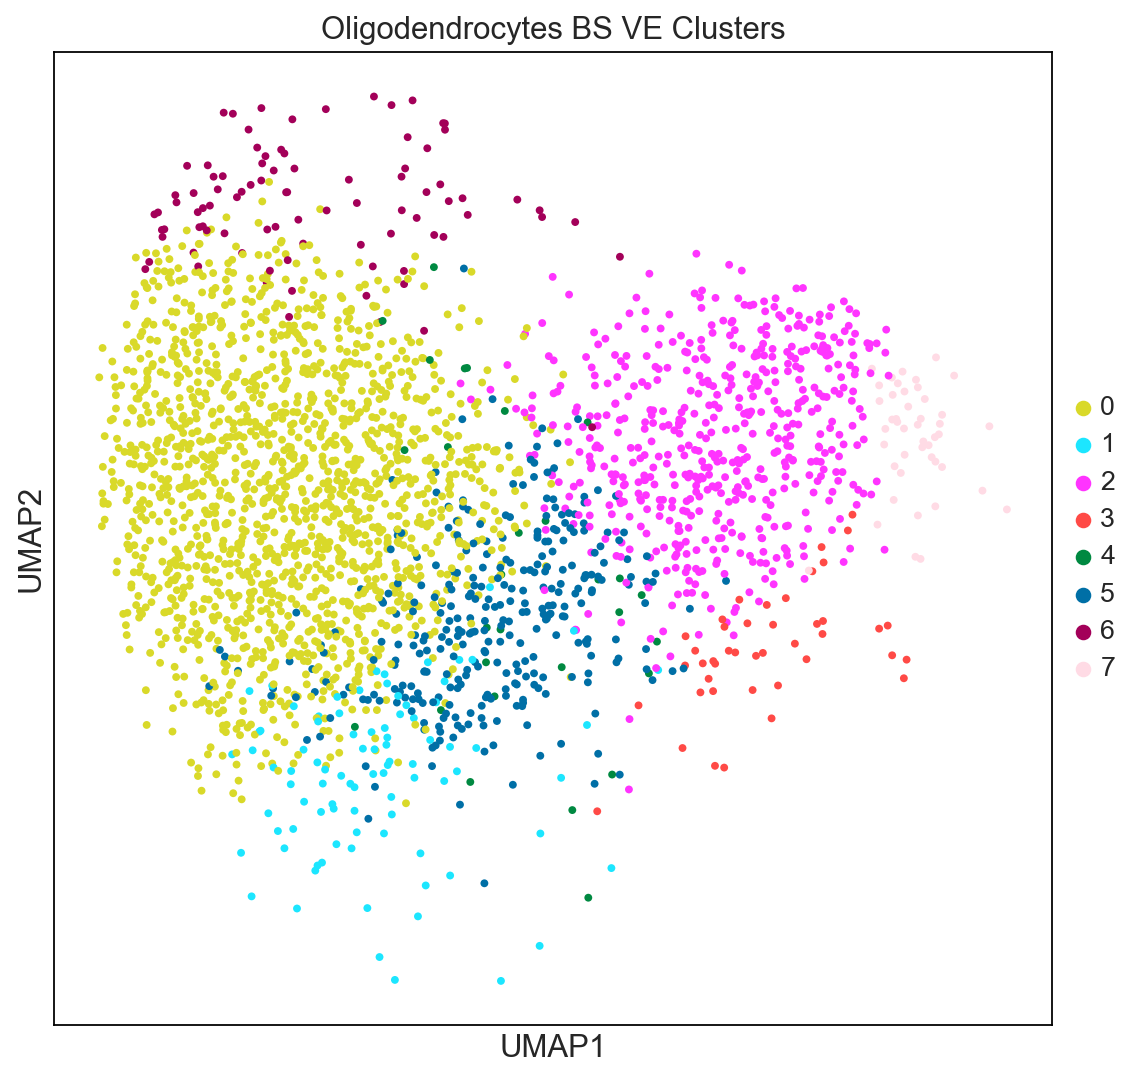

In [51]:
adata_oligo_BS_VE = adata_oligo_BS[adata_oligo_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_BS_VE, 
           color= ['PhenoGraph_clusters_oligo'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes BS VE Clusters"])

In [52]:
cell_counts_per_cluster_BS_VE = adata_oligo_BS_VE.obs.PhenoGraph_clusters_oligo.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

PhenoGraph_clusters_oligo
0                       1588
2                        549
5                        320
1                         89
6                         89
7                         45
3                         43
4                         29

### Heatmaps of gene expression

In [64]:
marker_genes_dict = dict()

marker_genes_dict = {'Oligo-BS':['PTGDS',
'ADIPOR2',
'ACACA',
'MEG3',
'CDC42BPA',
'MOBP',
'OTUD7A',
'CMSS1',
'ELMO1',
'ST6GALNAC3',
]}



categories: Oligo0_Control, Oligo0_VE, Oligo1_Control, etc.
var_group_labels: Oligo-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


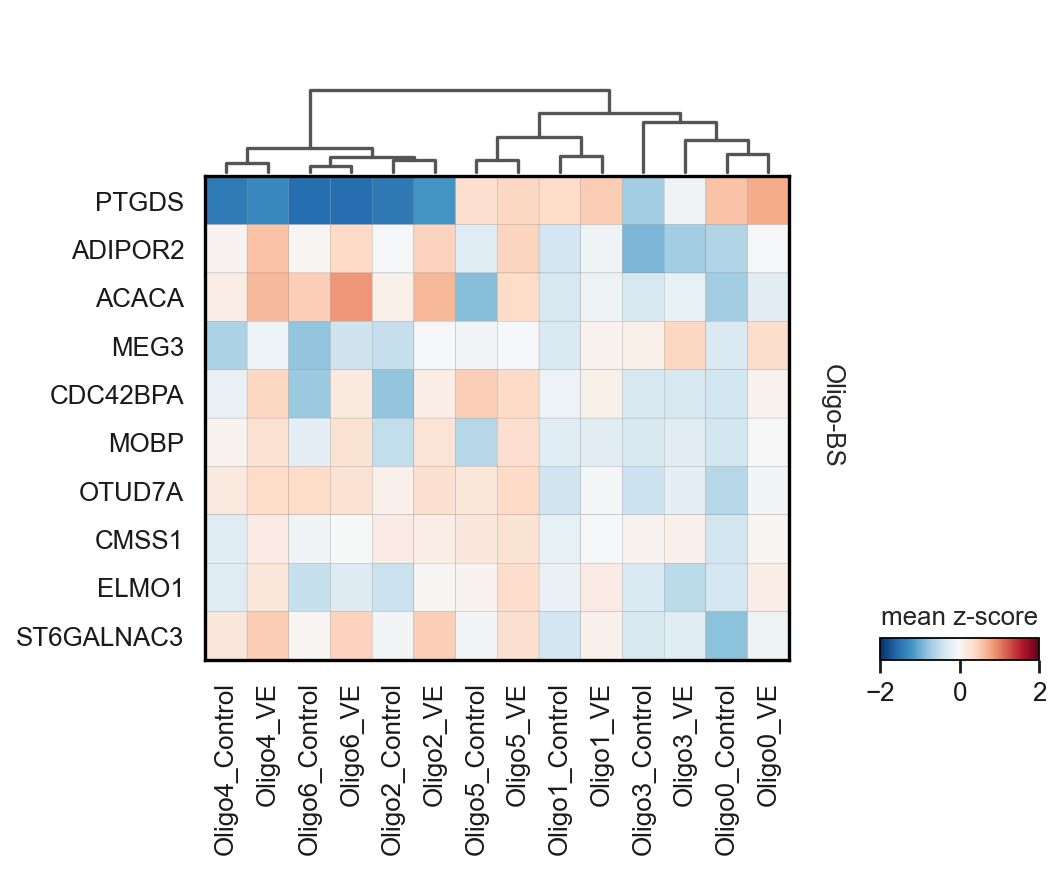

categories: Oligo0_Control, Oligo0_VE, Oligo1_Control, etc.
var_group_labels: Oligo-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


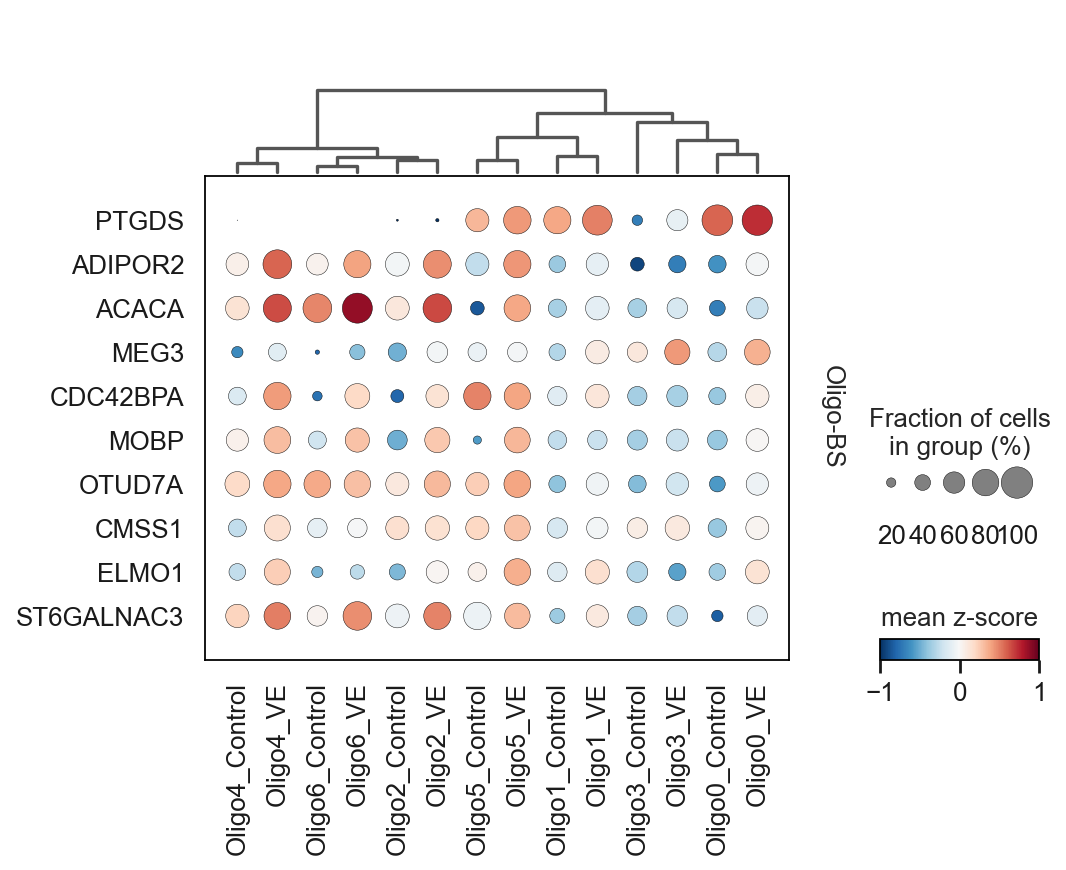

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


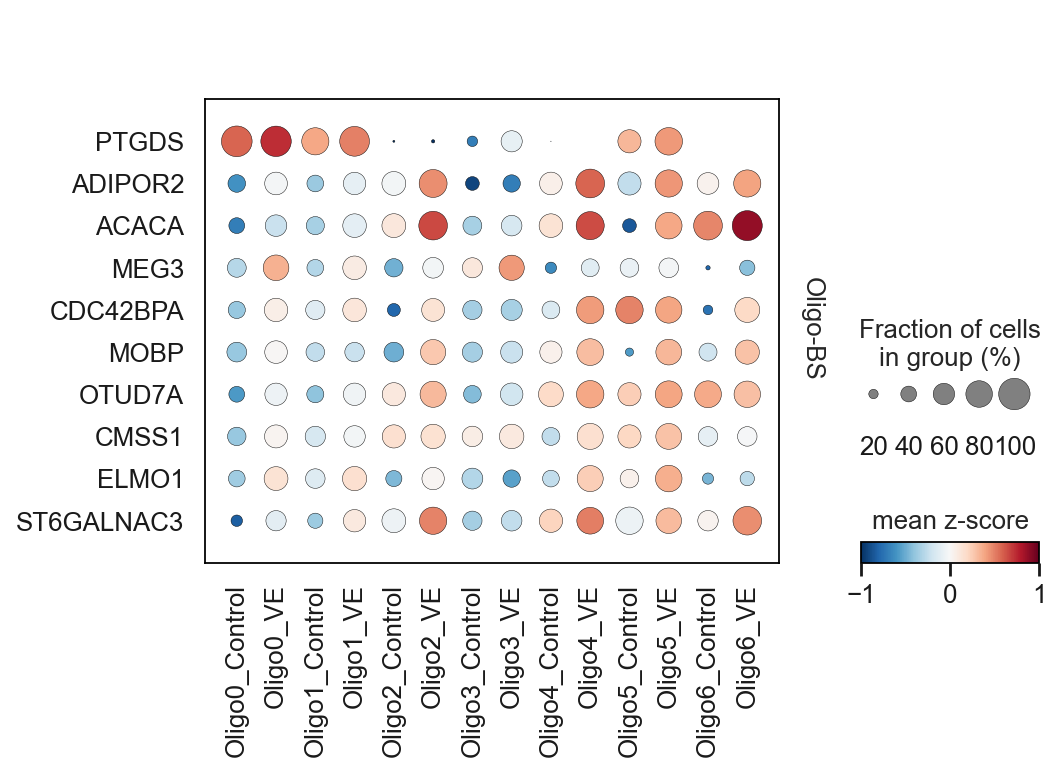

In [65]:
adata_oligo_BS.layers['scaled'] = sc.pp.scale(adata_oligo_BS, copy=True).X
sc.pl.matrixplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_oligo_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

In [ ]:
adata_oligo_BS.obs.PhenoGraph_clusters_oligo.value_counts()

## Oligo Cortex

In [70]:
adata_oligo_cortex = adata_oligo.copy()
adata_oligo_cortex = adata_oligo_cortex[adata_oligo_cortex.obs['B_region'].isin(['Cortex']),:]
adata_oligo_cortex.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(672, 13466)

In [71]:
adata_oligo_cortex.obs.Condition.value_counts()

Control    363
VE         309
Name: Condition, dtype: int64

Trying to set attribute `.uns` of view, copying.


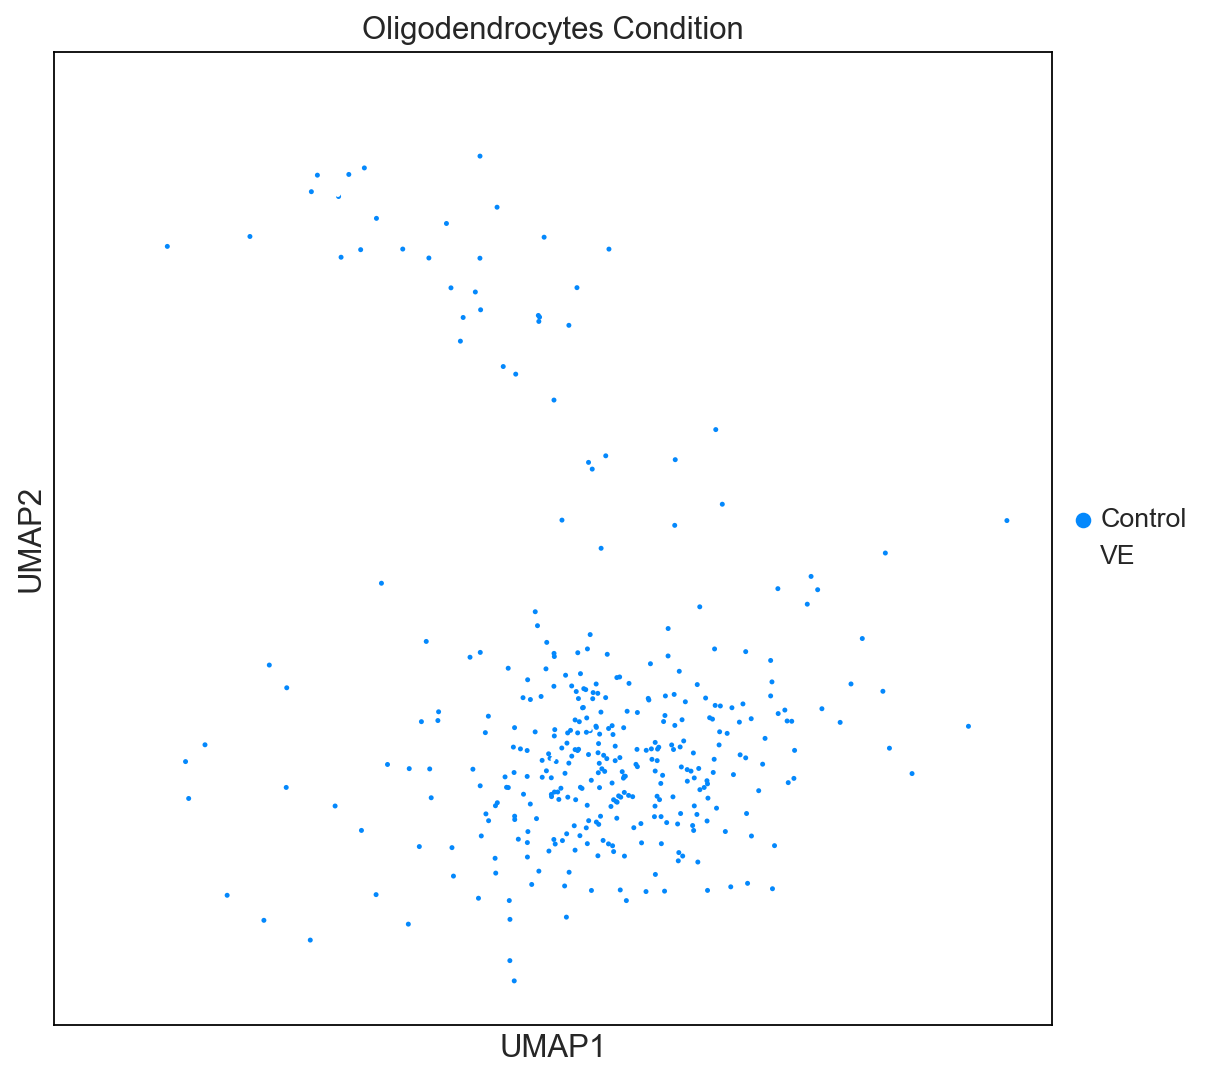

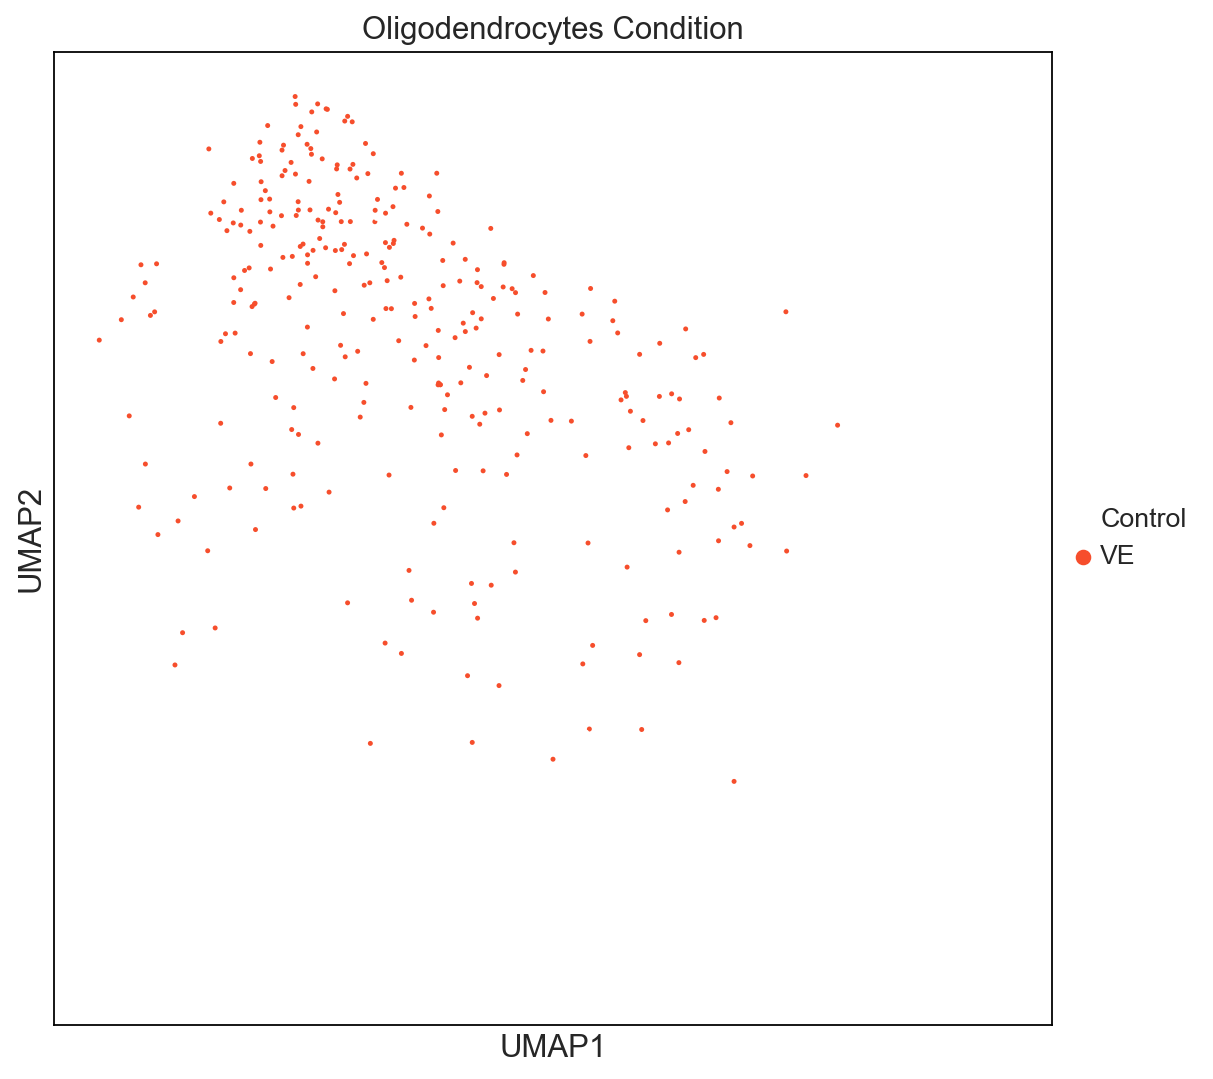

In [72]:
sc.pl.umap(adata_oligo_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=20, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Condition"])


sc.pl.umap(adata_oligo_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=20, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Condition"])

### Oligodendrocytes Cortex control 

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


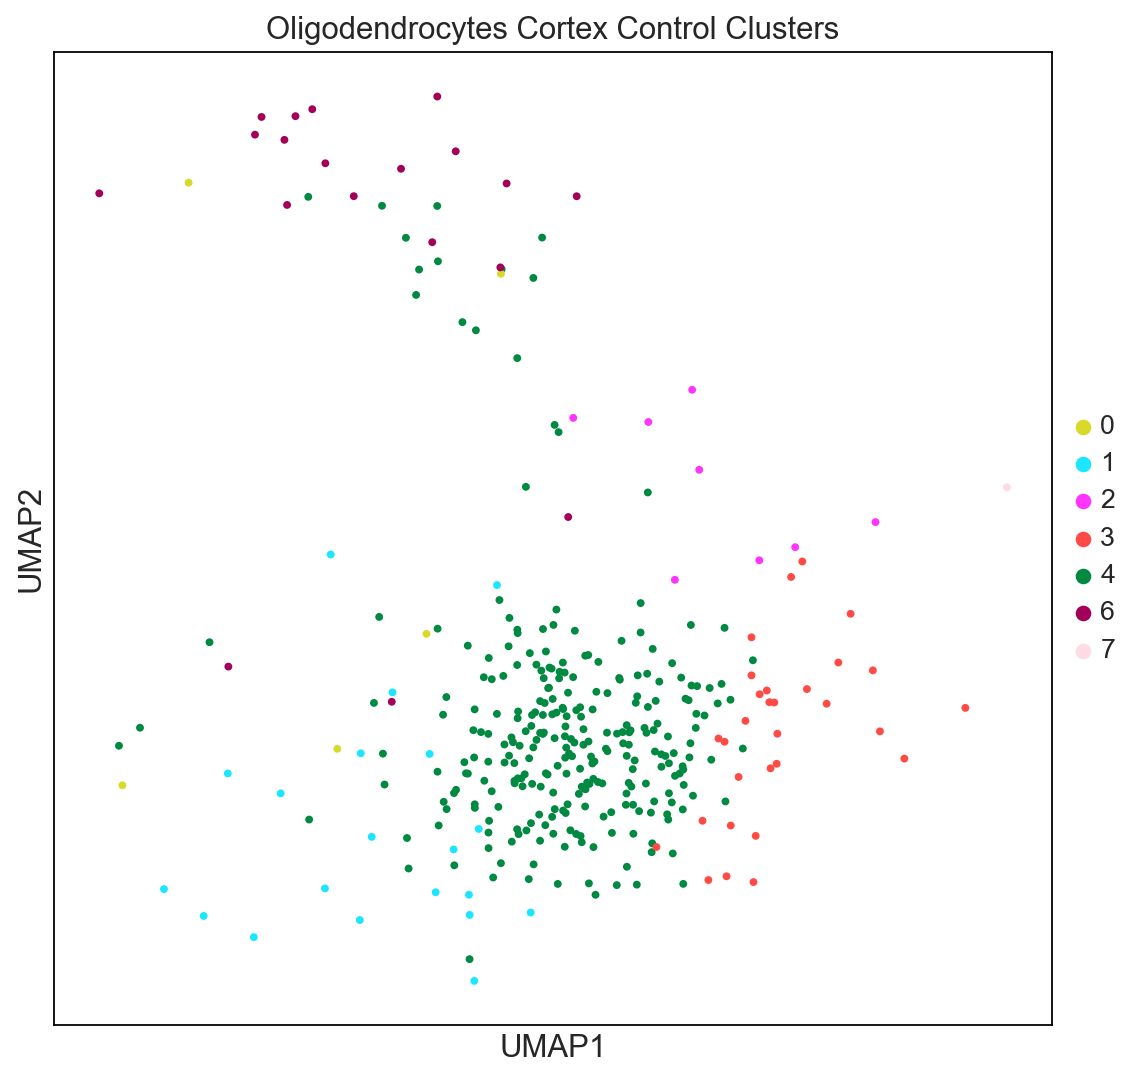

In [82]:
adata_oligo_cortex_control = adata_oligo_cortex[adata_oligo_cortex.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_cortex_control, 
           color= ['PhenoGraph_clusters_oligo'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#A30059","#FFDBE5"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Cortex Control Clusters"])

In [74]:
cell_counts_per_cluster_cortex_control = adata_oligo_cortex_control.obs.PhenoGraph_clusters_oligo.value_counts()
cell_counts_per_cluster_cortex_control = cell_counts_per_cluster_cortex_control.to_frame()
cell_counts_per_cluster_cortex_control

PhenoGraph_clusters_oligo
4                        280
3                         30
1                         20
6                         19
2                          8
0                          5
7                          1

### Oligodendrocytes cortex VE

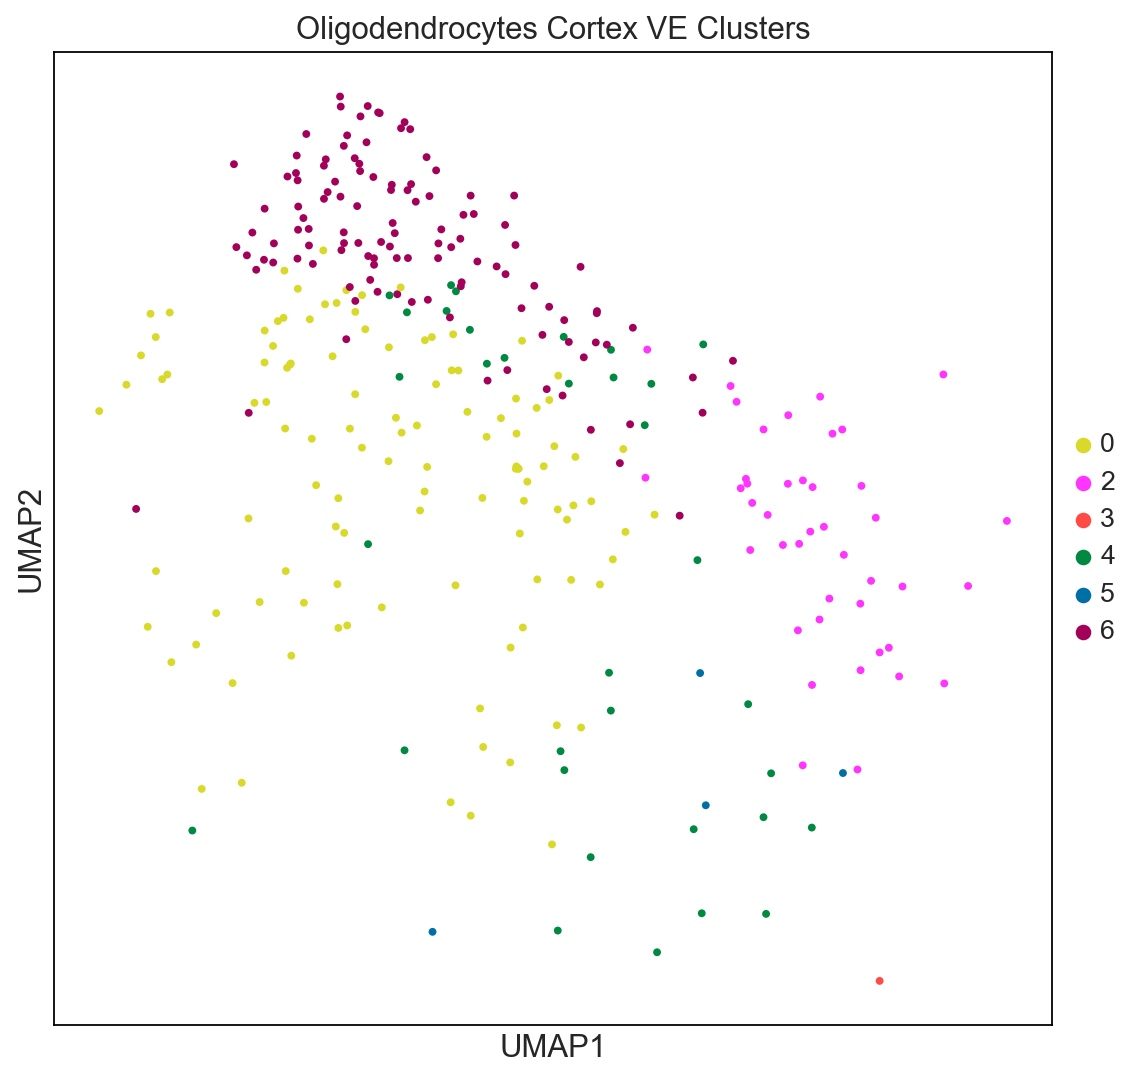

In [83]:
adata_oligo_cortex_VE = adata_oligo_cortex[adata_oligo_cortex.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_oligo_cortex_VE, 
           color= ['PhenoGraph_clusters_oligo'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Cortex VE Clusters"])

In [76]:
 cell_counts_per_cluster_cortex_VE = adata_oligo_cortex_VE.obs.PhenoGraph_clusters_oligo.value_counts()
cell_counts_per_cluster_cortex_VE = cell_counts_per_cluster_cortex_VE.to_frame()
cell_counts_per_cluster_cortex_VE

PhenoGraph_clusters_oligo
6                        116
0                        112
2                         42
4                         34
5                          4
3                          1

### Heatmaps of gene expression

In [74]:
marker_genes_dict = dict()

marker_genes_dict = {'Oligo-Cortex':[]}



categories: Oligo0_Control, Oligo0_VE, Oligo1_Control, etc.
var_group_labels: Oligo-Cortex


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


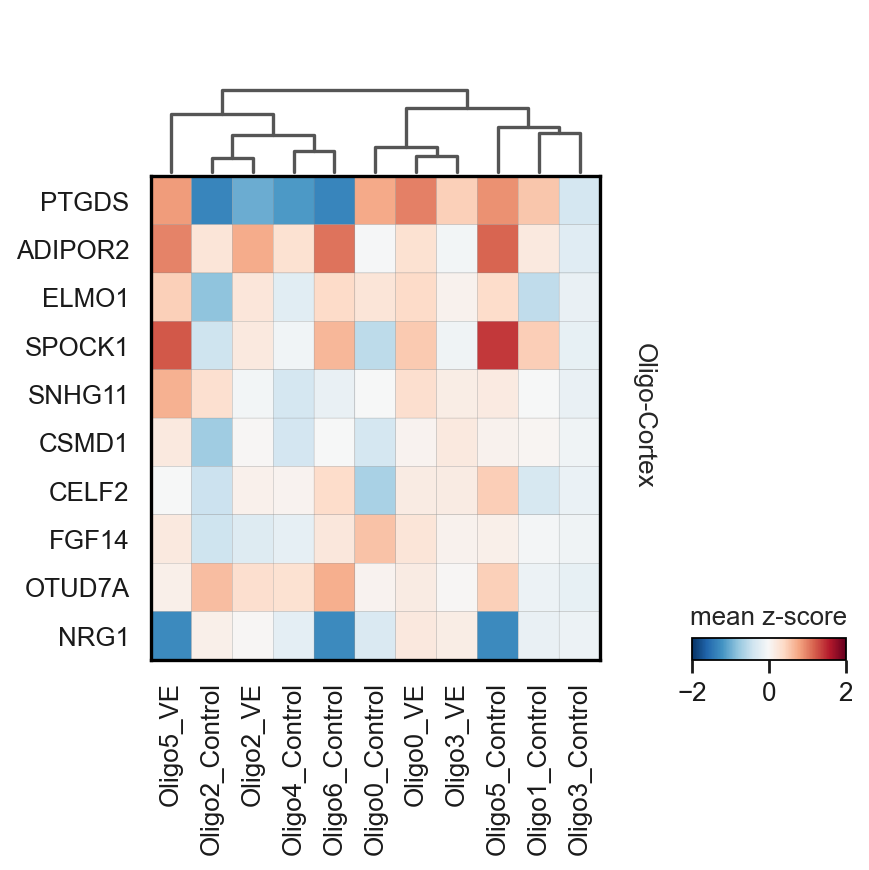

categories: Oligo0_Control, Oligo0_VE, Oligo1_Control, etc.
var_group_labels: Oligo-Cortex


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


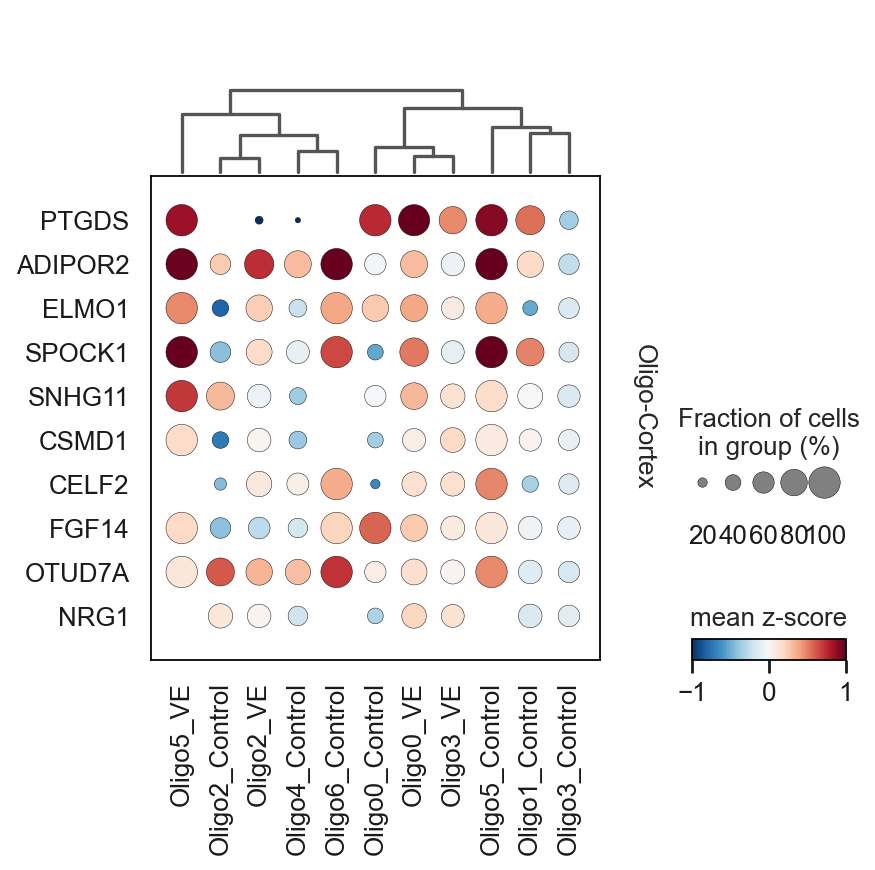

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


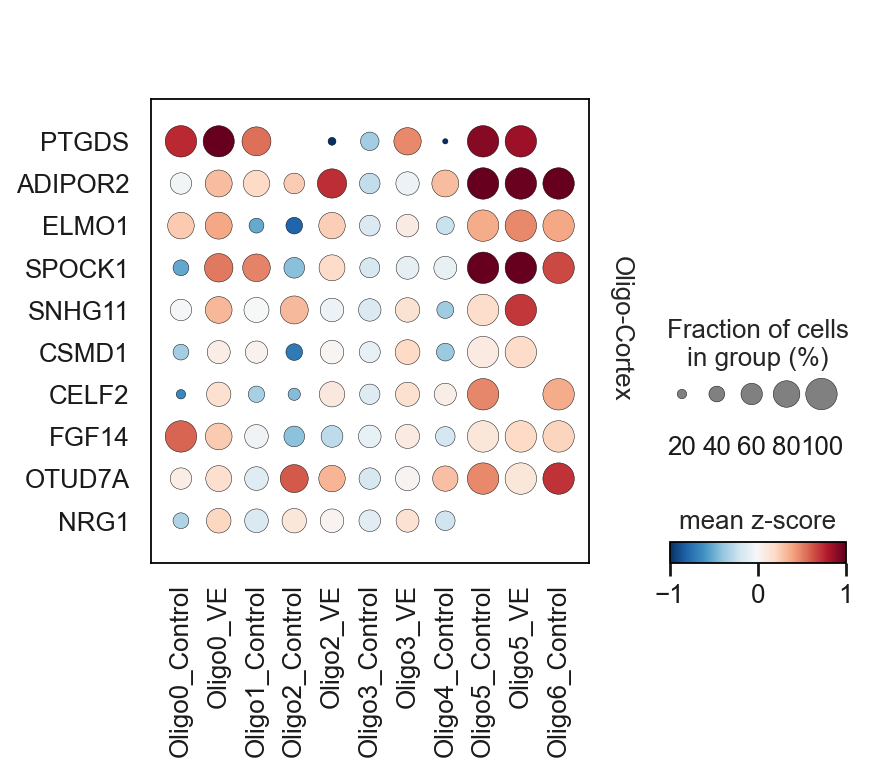

In [93]:
 adata_oligo_cortex.layers['scaled'] = sc.pp.scale( adata_oligo_cortex, copy=True).X
sc.pl.matrixplot( adata_oligo_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)


sc.pl.dotplot( adata_oligo_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot( adata_oligo_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_oligo_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

### Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [53]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'),how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_oligo_Control' : 'Control', 'PhenoGraph_clusters_oligo_VE' : 'VE'}, inplace = True)
mergedDF

Control    VE
0       69  1588
1      713    89
2       40   549
3      364    43
4       50    29
5        9   320
6       21    89
7      114    45

In [54]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

ClusterID Condition  N_cells
0          0   Control       69
1          1   Control      713
2          2   Control       40
3          3   Control      364
4          4   Control       50
5          5   Control        9
6          6   Control       21
7          7   Control      114
8          0        VE     1588
9          1        VE       89
10         2        VE      549
11         3        VE       43
12         4        VE       29
13         5        VE      320
14         6        VE       89
15         7        VE       45

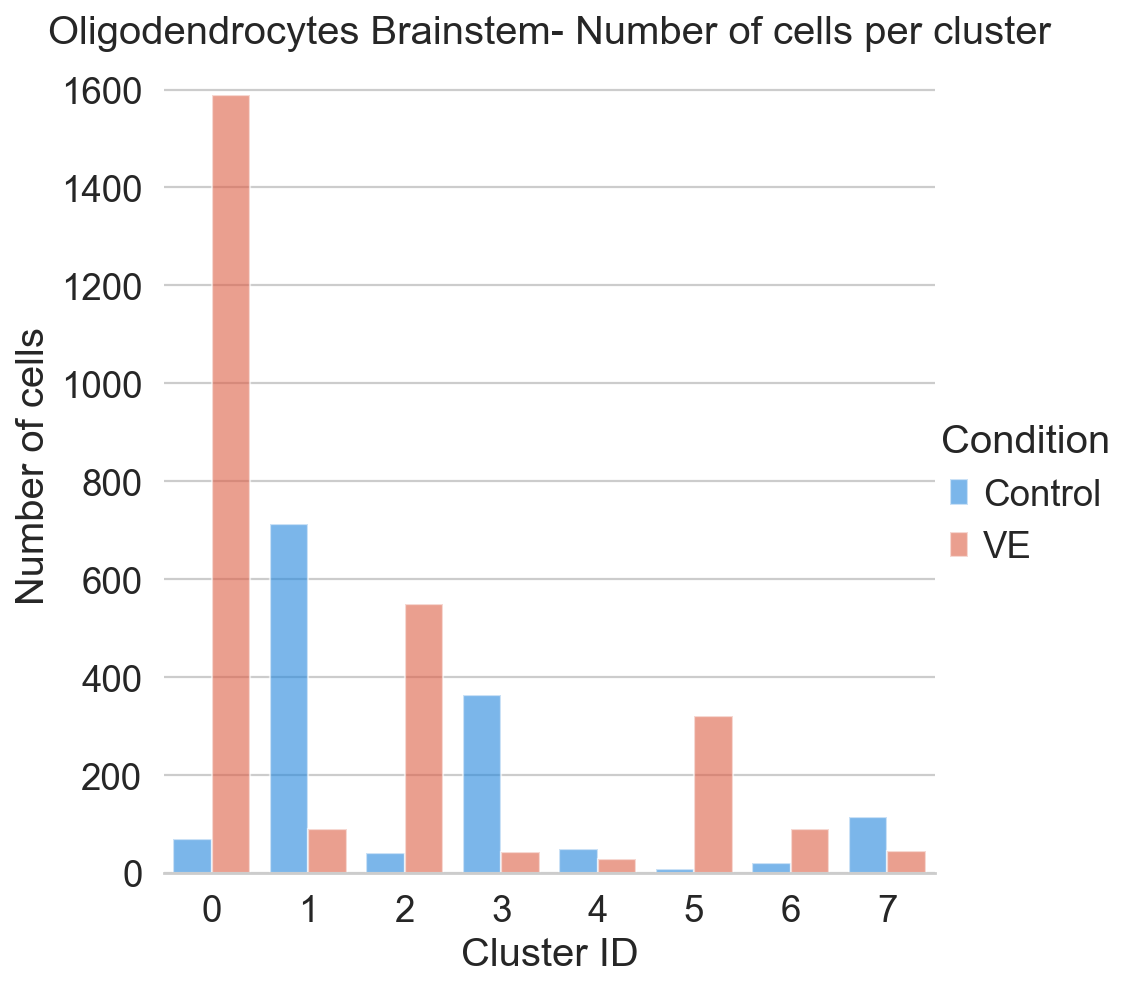

In [55]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Oligodendrocytes Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

**Cortex**

In [77]:
# First merge the 2 data frames by indeces
mergedDF_2= cell_counts_per_cluster_cortex_control.merge(cell_counts_per_cluster_cortex_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'), how = 'outer')
mergedDF_2.rename(columns = {'PhenoGraph_clusters_oligo_Control' : 'Control', 'PhenoGraph_clusters_oligo_VE' : 'VE'}, inplace = True)
mergedDF_2

Control     VE
0      5.0  112.0
1     20.0    NaN
2      8.0   42.0
3     30.0    1.0
4    280.0   34.0
5      NaN    4.0
6     19.0  116.0
7      1.0    NaN

In [78]:
mergedDF_2 = mergedDF_2.reset_index()
mergedDF_2 = mergedDF_2.melt(id_vars=["index"])
mergedDF_2.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF_2

ClusterID Condition  N_cells
0           0   Control      5.0
1           1   Control     20.0
2           2   Control      8.0
3           3   Control     30.0
4           4   Control    280.0
5           5   Control      NaN
6           6   Control     19.0
7           7   Control      1.0
8           0        VE    112.0
9           1        VE      NaN
10          2        VE     42.0
11          3        VE      1.0
12          4        VE     34.0
13          5        VE      4.0
14          6        VE    116.0
15          7        VE      NaN

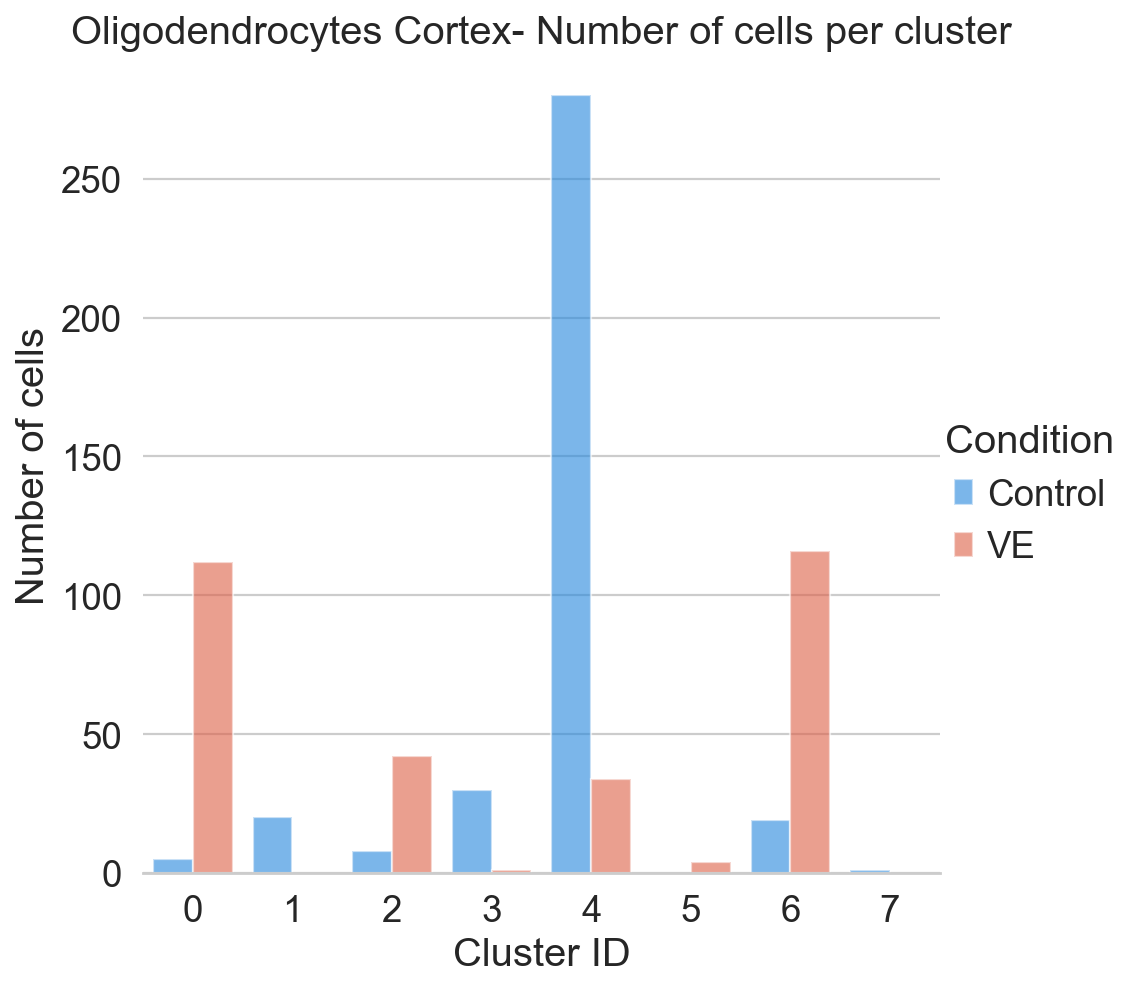

In [79]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF_2, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Oligodendrocytes Cortex- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")